In [6]:
import numpy as np
import sys, os, h5py, re
sys.path.append('..')
sys.path.append("../..")
import matplotlib.pyplot as plt
from learning_utils import prepare_data_flexdmp, calc_loss_flexdmp
from check_dyn import plot_res_6dof

In [10]:
# just for dyna error calc
from casadi_kinodynamics.utils import symbolic_robot
sym_robot = symbolic_robot.symbolic_robot(robot_name='IRB1100_4_058',
                                          tool_mass=.0,
                                          tool_frame=[0., 0., 0.25, 0., 0., 0.],
                                          tool_cog=[0.0, 0., 0.12],
                                          tool_inertia=[
                                              0., 0., 0., 0., 0., 0.],
                                          load_casadi_fnc=True)

In [11]:
from trajencoder.flexdmp.flexdmp import FlexDMP
from algpr.gpr import GaussianProcessRegressor
from algpr.gpoegpr import GpoeGPR
from algpr.kernels import RBF
from algpr.ppgpr import PPGPR
from algpr.vigpr import VIGPR
# active learning environment
from data.cylinder_sampling import cylinder_sampling
from data.collect_data_6dof import Env6dof

In [12]:
DMP_ORDER = 40

In [14]:
Xv, Yv, Trueth, qd_trueth, qdd_trueth, tau_trueth = prepare_data_flexdmp("6dof/Vali_orientation.hdf5", FlexDMP, DMP_ORDER=DMP_ORDER, \
                                                             return_dyddy=True, return_tau=True, dof=6)

In [15]:
Yv.shape

(200, 241)

In [20]:
# initialize sampling space
from itertools import product
X_box1 = np.load("../../box1.npy")
X_box2 = np.load("../../box2.npy")
sampling_pool = np.array(list(product(X_box1, X_box2)))
sampling_pool = sampling_pool.reshape(-1, 12)
env = Env6dof()
sampling_pool.shape

(148225, 12)

In [23]:
index_sampling_pool = np.arange(len(sampling_pool))
nproc = os.cpu_count()
X_list = []
Y_list = []
for i in range(5):
    print(i)
    index_init = np.random.choice(index_sampling_pool, nproc)
    X_init = sampling_pool[index_init]
    Qi = X_init[:,:6].tolist()
    Qf = X_init[:,6:].tolist()
    Mass = [0. for _ in range(nproc)]
    Xi, traj_list = env.batch_record_multiprocessing(Qi, Qf, Mass)
    Xi = np.array(Xi)
    Yi = env.prepare_data_flexdmp(traj_list, FlexDMP, DMP_ORDER)
    X_list.append(Xi)
    Y_list.append(Yi)

0
1
2
3
4


In [24]:
X = np.concatenate(X_list)
Y = np.concatenate(Y_list)

In [31]:
gpr_t = GaussianProcessRegressor(kernel=RBF(l=np.array([1.6]*13), anisotropic=True))
gpr_t.fit(X, Y[:,-1])

gpr_dmp = GaussianProcessRegressor(kernel=RBF(l=np.array([1.6]*13), anisotropic=True))
gpr_dmp.fit(X, Y[:,:-1])

The evidence is:  -41979.76167222079
The evidence is:  -7183849432.047224


-7183849432.047224

In [32]:
pred_t, full_var = gpr_t.predict(Xv, return_var=True)
pred_dmp, full_var = gpr_dmp.predict(Xv, return_var=True)
pred = np.concatenate([pred_dmp, pred_t], axis=1)
print(pred.shape)
pred[pred[:,-1] < 1.] = 1.1

(200, 241)


In [33]:
error_time, error_target_q, error_dyn_loss, dyna_info = calc_loss_flexdmp(pred, Xv, Yv, Trueth, DMP_ORDER, dof=6,\
                 return_dyn_loss=True, return_dyn_info=True)
print(error_time, error_target_q, error_dyn_loss)

The rate of dyna violation:  62.0 %
The peak dyna violation:  [106.26962861  19.33249772  14.60955123   0.           1.90453627
   2.92804391]
Peak dyna violation occurs at:  [ 78.  77. 163.   0.   7.  84.]
The peak vel non-zero:  [5.60253626 2.9016441  4.75048726 1.54465942 4.44296655 7.0760696 ]
0.21457999999999985 0.04292956656051409 0.33434933278735157


### Update: box to box training loop

In [52]:
sampling_pool = np.concatenate([sampling_pool, np.zeros([len(sampling_pool), 1])], axis=1)
sampling_pool.shape

(148225, 13)

In [61]:
## records
time_error_l = []
peak_vio = []

kernel_l = np.array([1.6]*13)
for i in range(1200):
    pred_t, full_var = gpr_t.predict(sampling_pool, return_var=True)
    
    ind = np.argsort(full_var.squeeze())[-nproc:]
    #########################################################
    X_choosen = sampling_pool[ind]
    Qi, Qf = X_choosen[:,:6].tolist(), X_choosen[:,6:12].tolist()
    Mass = X_choosen[:,12].tolist()
    Xi, traj_list = env.batch_record_multiprocessing(Qi, Qf, Mass)
    Yi = env.prepare_data_flexdmp(traj_list, FlexDMP, DMP_ORDER)
    X = np.append(X, Xi, axis=0)
    Y = np.append(Y, Yi, axis=0)
    print(i, " th round..., ", "current data points: ", len(X))
    ########################################################
    if len(X) > 3000 and len(X) < 10000:
        m = int( len(X)//2.5 )
        gpr_t = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
        gpr_t.fit(X, Y[:,-1], m=m)
        gpr_dmp = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
    elif len(X) > 10000:
        m = len(X)//3
        gpr_t = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
        gpr_t.fit(X, Y[:,-1], m=m)
        gpr_dmp = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
    else:
        m = int( len(X)//1.5 )
        gpr_t = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
        gpr_t.fit(X, Y[:,-1], m=m)
        gpr_dmp = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
        
    if i % 20 == 0:
        pred_t = gpr_t.predict(Xv)
        pred_t[pred_t[:,-1] < 1.] = 1.1
        gpr_dmp.fit(X, Y[:,:-1], m=m)
        pred_dmp = gpr_dmp.predict(Xv)
        pred = np.concatenate([pred_dmp, pred_t], axis=1)
        error_time, error_target_q, error_dyn_loss, dyna_info = calc_loss_flexdmp(pred, Xv, Yv, Trueth, DMP_ORDER, dof=6,\
                         return_dyn_loss=True, return_dyn_info=True)
        print(error_time, error_target_q, error_dyn_loss)
        time_error_l.append(error_time)
        peak_vio.append( np.max(dyna_info['vio_peak']) )

0  th round...,  current data points:  72
The rate of dyna violation:  67.0 %
The peak dyna violation:  [148.93199011  20.72118578  14.56381348   0.           3.00080817
   4.35683645]
Peak dyna violation occurs at:  [106.  70. 163.   0.   7.  84.]
The peak vel non-zero:  [6.59249045 3.56129471 5.68291704 2.56233678 5.33563957 8.3939036 ]
0.20975999999999995 0.0419255758923436 0.5416459772619283
1  th round...,  current data points:  84
2  th round...,  current data points:  96
3  th round...,  current data points:  108
4  th round...,  current data points:  120
5  th round...,  current data points:  132
6  th round...,  current data points:  144
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
7  th round...,  current data points:  156
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
8  th round...,  current data points:  168
The cho_factor meet singular matrix


KeyboardInterrupt



### Training loop

In [13]:
from itertools import product
active = True
batch_size = 150
index_len = len(sampling_pool)
index_sampling_pool = np.arange(index_len)
UCB_Qi = np.zeros(index_len) # counters
UCB_Qf = np.zeros(index_len)

def generate_index_ucb(UCB_Qi, index_sampling_pool, t):
    zero_num_qi = len(index_sampling_pool[UCB_Qi==0])
    if zero_num_qi >= batch_size:
        index_init_Qi = np.random.choice(index_sampling_pool[UCB_Qi==0], batch_size, replace=False)
        UCB_Qi[index_init_Qi] += 1
    elif zero_num_qi > 0 and zero_num_qi < batch_size:
        index_init_Qi = index_sampling_pool[UCB_Qi==0]
        UCB_Qi[index_init_Qi] += 1
        Qi_p = np.ones_like(UCB_Qi)*0.1 + 1.5 * np.sqrt( np.log(t) / UCB_Qi )
        Qi_p = Qi_p / Qi_p.sum()
        index_temp = np.random.choice(index_sampling_pool, batch_size-zero_num_qi, replace=False, p=Qi_p)
        UCB_Qi[index_temp] += 1
        index_init_Qi = np.concatenate([index_init_Qi, index_temp])
    else:
        Qi_p = np.ones_like(UCB_Qi)*0.1 + 1.5 * np.sqrt( np.log(t) / UCB_Qi )
        Qi_p = Qi_p / Qi_p.sum()
        index_init_Qi = np.random.choice(index_sampling_pool, batch_size, replace=False, p=Qi_p)
        UCB_Qi[index_init_Qi] += 1
    return UCB_Qi, index_init_Qi

In [14]:
time_error_l = []
kernel_l = np.array([1.8]*13)

Mass_pool = np.array([0.5 for _ in range(batch_size**2)]).reshape(-1,1)
uncertainty_threshold = 0.
for i in range(1200):
    if active:
        ind = np.zeros(nproc, dtype=int)
        curr_ind = 0
        for search_i in range(1000): # maximum search 10 times
            print("--- I'm searching... ---")
            ### introduce Upper confidence bound here
            UCB_Qi, index_init_Qi = generate_index_ucb(UCB_Qi, index_sampling_pool, i)
            UCB_Qf, index_init_Qf = generate_index_ucb(UCB_Qf, index_sampling_pool, i)
            ###
            Qi_pool = np.array(sampling_pool[index_init_Qi], dtype=float)
            Qf_pool = np.array(sampling_pool[index_init_Qf], dtype=float)
            X_pool = np.array(list(product(Qi_pool, Qf_pool)), dtype=float).reshape(batch_size**2, 12)
            X_pool = np.concatenate([X_pool, Mass_pool], axis=1)
            ##### Criterion, uncertainty sampling / multual information
            _, var_pool = gpr_t.predict(X_pool, return_var=True)
            #####
            ind_candidates = np.argpartition(var_pool.flatten(), -nproc)[-nproc:]
            good_candi = ind_candidates[(var_pool[ind_candidates] > uncertainty_threshold).squeeze()]
            if curr_ind+len(good_candi) <= nproc:
                ind[curr_ind:curr_ind+len(good_candi)] = good_candi
                curr_ind += len(good_candi)
                print("--- Found ", len(good_candi), " good points. ---")
            elif curr_ind < nproc and curr_ind+len(good_candi) > nproc:
                ind[curr_ind:] = good_candi[:(nproc-curr_ind)]
                curr_ind += (nproc-curr_ind)
                print("--- Batch is full... ---")
            if curr_ind == nproc:
                print("--- Increase the threshold... ---")
                uncertainty_threshold = np.min(var_pool[ind])
                break
            if search_i > 0 and search_i % 5 == 0:
                print("--- Lower the threshold... ---")
                uncertainty_threshold *= 0.95
    else:
        pass
    #########################################################
    X_choosen = X_pool[ind]
    Qi, Qf = X_choosen[:,:6].tolist(), X_choosen[:,6:-1].tolist()
    Mass = [0.5 for _ in range(nproc)]
    Xi, traj_list = env.batch_record_multiprocessing(Qi, Qf, Mass)
    Yi = env.prepare_data_flexdmp(traj_list, FlexDMP, DMP_ORDER)
    X = np.append(X, Xi, axis=0)
    Y = np.append(Y, Yi, axis=0)
    print(i, " th round..., ", "current data points: ", len(X))
    ########################################################
    if len(X) > 3000 and len(X) < 10000:
        m = int( len(X)//2.5 )
        gpr_t = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
        gpr_t.fit(X, Y[:,-1], m=m)
        gpr_dmp = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
    elif len(X) > 10000:
        m = len(X)//3
        gpr_t = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
        gpr_t.fit(X, Y[:,-1], m=m)
        gpr_dmp = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
    else:
        m = int( len(X)//1.5 )
        gpr_t = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
        gpr_t.fit(X, Y[:,-1], m=m)
        gpr_dmp = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
        
    if i % 20 == 0:
        pred_t = gpr_t.predict(Xv)
        pred_t[pred_t[:,-1] < 1.] = 1.1
        gpr_dmp.fit(X, Y[:,:-1], m=m)
        pred_dmp = gpr_dmp.predict(Xv)
        pred = np.concatenate([pred_dmp, pred_t], axis=1)
        error_time, error_target_q, error_dyn_loss, dyna_info = calc_loss_flexdmp(pred, Xv, Yv, Trueth, DMP_ORDER, dof=6,\
                         return_dyn_loss=True, return_dyn_info=True)
        print(error_time, error_target_q, error_dyn_loss)
        time_error_l.append(error_time)

--- Found  12  good points. ---
--- Increase the threshold... ---
Problem model generated. 


Problem model generated. Warning: Default initialization.
Problem model generated. 


Problem model generated. 

NLP with 399 variables and 620 constraints generated.Problem model generated. Problem model generated. 



Problem model generated. Warning: Default initialization.NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.Problem model generated. Warning: Default initialization.


Problem model generated. 
NLP with 399 variables and 620 constraints generated.

NLP with 399 variables and 620 constraints generated.

NLP with 399 variables and 620 constraints generated.Warning: Default initialization.NLP with 399 variables and 620 constraints generated.


NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.
Solver instantiated.

*

Solver instantiated.Solver instantiated.      solver 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

       nlp_f  | 224.00us ( 17.23us) 221.42us ( 17.

--- I'm searching... ---
--- Found  10  good points. ---
--- I'm searching... ---
--- Batch is full... ---
--- Increase the threshold... ---
Problem model generated. 
Problem model generated. 

Problem model generated. 
Problem model generated. 
Problem model generated. Warning: Default initialization.
NLP with 399 variables and 620 constraints generated.
Problem model generated. 

Problem model generated. 



Problem model generated. 


NLP with 399 variables and 620 constraints generated.



NLP with 399 variables and 620 constraints generated.

NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constraints generated.

NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimizati

      solver       solver  |  43.86ms (  2.74ms)  46.57ms (  2.91ms)        16
 |  76.54ms (  3.19ms) 116.63ms (  4.86ms)        24
       total    nlp_jac_g    nlp_jac_g  | 314.18ms (314.18ms) 367.83ms (367.83ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  44.18ms (  1.70ms)  48.29ms (  1.86ms)        26
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f       solver        total  | 696.00us (  8.39us) 697.37us (  8.40us)        83
      solver  |  26.18ms (  1.45ms)  27.04ms (  1.50ms)        18
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        nlp_g        total        nlp_f  | 162.83ms (162.83ms) 200.55ms (200.55ms)         1
 | 275.24ms (275.24ms) 379.96ms (379.96ms)         1
 | 172.00us (  9.05us) 169.10us (  8.90us)        19
 |  13.38ms (161.23us)  21.86ms (263.32us)        83
       nlp_g  |   1.13ms (  8.88us)   1.15ms (  9.09us)       127
  nlp_grad_f        nlp_g       solver  :   t_proc      (avg)   t_wall      

  nlp_hess_l  | 136.72ms (  2.73ms) 137.43ms (  2.75ms)        50
   nlp_jac_g  |  76.09ms (  1.46ms)  76.39ms (  1.47ms)        52
       total  | 576.65ms (576.65ms) 619.08ms (619.08ms)         1
1012  th round...,  current data points:  12216
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
--- I'm searching... ---
--- Found  12  good points. ---
--- Increase the threshold... ---
Problem model generated. 
Problem model generated. Warning: Default initialization.


Problem model generated. Warning: Default initialization.

Problem model generated. 
Problem model generated. Warning: Default initialization.NLP with 399 variables and 620 constraints generated.


Problem model generated. Problem model generated. 

NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.Problem model generated. Warning: Default initialization.
Problem model generated. NLP with 399 variables an

 | 492.00us (  9.28us) 489.96us (  9.24us)        53
       nlp_g  |   9.07ms (168.00us)   9.66ms (178.83us)        54
       nlp_g  |   9.39ms (177.08us)   9.44ms (178.06us)        53
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f       solver   nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_grad_f        nlp_f  | 646.00us (  8.39us) 650.95us (  8.45us)        77
      solver  | 637.00us (  8.49us) 626.55us (  8.35us)        75
       nlp_g  | 749.00us ( 24.16us) 755.28us ( 24.36us)        31
  nlp_hess_l        nlp_g  | 788.00us ( 25.42us) 785.31us ( 25.33us)        31
 |  85.58ms (  2.95ms)  86.76ms (  2.99ms)        29
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  12.27ms (163.67us)  12.36ms (164.78us)        75
      solver    nlp_jac_g   nlp_hess_l  |  51.46ms (  1.56ms)  52.68ms (  1.60ms)        33
 |  86.88ms (  3.00ms)  87.22ms (  3.01ms)        29
       total   nlp_grad_f  | 291.07ms (291.07ms) 315.78ms (315.78ms)        


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is 

  nlp_grad_f  | 204.51ms (204.51ms) 228.90ms (228.90ms)         1
 | 885.00us ( 32.78us) 879.50us ( 32.57us)        27
       nlp_f   nlp_hess_l       solver  |   1.08ms (  8.74us)   1.09ms (  8.77us)       124
 |  99.11ms (  3.54ms) 100.19ms (  3.58ms)        28
 :   t_proc      (avg)   t_wall      (avg)    n_eval
   nlp_jac_g        nlp_g        nlp_f  |  20.51ms (165.36us)  21.16ms (170.65us)       124
 |  61.29ms (  1.92ms)  61.58ms (  1.92ms)        32
  nlp_grad_f  | 389.00us ( 10.81us) 386.55us ( 10.74us)        36
       total  | 892.00us ( 27.03us) 887.46us ( 26.89us)        33
       nlp_g       solver  | 323.17ms (323.17ms) 333.43ms (333.43ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |   7.25ms (201.31us)   7.71ms (214.12us)        36
  nlp_grad_f  | 633.00us ( 25.32us) 649.19us ( 25.97us)        25
  nlp_hess_l        nlp_f   nlp_hess_l  |  69.57ms (  3.02ms)  84.94ms (  3.69ms)        23
      solver    nlp_jac_g  |  97.53ms (  3.15ms)  98.23ms (  3.



Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code und

      solver    nlp_jac_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  71.48ms (  1.59ms)  79.10ms (  1.76ms)        45
       total        nlp_f  |   1.02ms (  7.13us)   1.01ms (  7.07us)       143
       nlp_g  |  21.19ms (148.21us)  21.51ms (150.39us)       143
  nlp_grad_f  | 766.00us ( 20.70us) 762.35us ( 20.60us)        37
  nlp_hess_l  |  91.22ms (  2.61ms)  93.33ms (  2.67ms)        35
   nlp_jac_g  |  52.42ms (  1.42ms)  52.48ms (  1.42ms)        37
       total  | 344.93ms (344.93ms) 372.27ms (372.27ms)         1
 | 490.46ms (490.46ms) 545.27ms (545.27ms)         1
1016  th round...,  current data points:  12264
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
--- I'm searching... ---
--- Found  12  good points. ---
--- Increase the threshold... ---
Problem model generated. 

Problem model generated. Warning: Default initialization.Problem model generated. 




Problem model generated. NLP with 399 var

      solver   nlp_grad_f  | 420.00us ( 30.00us) 417.57us ( 29.83us)        14
       nlp_f   nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 578.00us ( 10.32us) 572.41us ( 10.22us)        56
 | 678.00us ( 28.25us) 678.10us ( 28.25us)        24
      solver        nlp_f        nlp_g  |  47.90ms (  3.42ms)  48.10ms (  3.44ms)        14
  nlp_hess_l  | 604.00us ( 12.08us)   2.49ms ( 49.78us)        50
  nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  10.43ms (186.25us)  11.86ms (211.80us)        56
 |  34.60ms (  2.88ms)  35.66ms (  2.97ms)        12
       nlp_f   nlp_grad_f  |  11.37ms (227.30us)  11.48ms (229.51us)        50
   nlp_jac_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_grad_f  | 838.00us ( 28.90us) 877.63us ( 30.26us)        29
  nlp_hess_l  | 658.00us ( 26.32us) 711.62us ( 28.46us)        25
 |  29.57ms (  1.85ms)  29.59ms (  1.85ms)        16
   nlp_jac_g        total  | 167.97ms (167.97ms) 180.09ms (180.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval

******************************************************************************
This program c

 |  20.22ms (  1.44ms)  34.79ms (  2.49ms)        14
       total       solver  | 388.00us ( 11.76us) 381.41us ( 11.56us)        33
  nlp_hess_l  | 116.19ms (116.19ms) 161.44ms (161.44ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  65.84ms (  3.29ms)  73.43ms (  3.67ms)        20
      solver        nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f    nlp_jac_g  |  36.74ms (  1.67ms)  39.98ms (  1.82ms)        22
 |   6.68ms (202.30us)   6.67ms (202.17us)        33
       nlp_f   nlp_grad_f        total  | 533.00us ( 10.66us) 547.95us ( 10.96us)        50
 | 204.45ms (204.45ms) 239.44ms (239.44ms)         1
 | 701.00us ( 28.04us) 696.62us ( 27.86us)        25
      solver   nlp_hess_l        nlp_g  | 275.00us ( 14.47us) 273.01us ( 14.37us)        19
 |  76.56ms (  3.33ms) 104.52ms (  4.54ms)        23
       nlp_g    nlp_jac_g  |   3.95ms (208.00us)   3.95ms (207.69us)        19
 |   9.60ms (192.04us)   9.88ms (197.56us)        50
 |  43.47m


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.
Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

 | 503.00us ( 12.27us) 501.24us ( 12.23us)        41
  nlp_grad_f        nlp_g  |   8.72ms (212.76us)   8.81ms (214.96us)        41
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 757.00us ( 28.04us) 750.37us ( 27.79us)        27
  nlp_grad_f        nlp_f  | 836.00us ( 28.83us) 834.13us ( 28.76us)        29
  nlp_hess_l   nlp_hess_l  |  99.47ms (  3.32ms)  99.69ms (  3.32ms)        30
 | 664.00us (  9.76us) 674.37us (  9.92us)        68
 |  87.47ms (  3.24ms)  90.47ms (  3.35ms)        27
   nlp_jac_g    nlp_jac_g  |  60.19ms (  1.77ms)  60.23ms (  1.77ms)        34
       nlp_g  |  11.85ms (174.29us)  11.85ms (174.21us)        68
      solver   nlp_grad_f       solver       solver        total  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 242.00us ( 11.00us) 252.06us ( 11.46us)        22
       nlp_g  |   4.25ms (193.09us)   4.26ms (193.63us)        22
  nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 324.00us (  7.71us) 3


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

       total  :   t_proc      (avg)   t_wall      (avg)    n_eval
       total        nlp_f  | 350.33ms (350.33ms) 407.22ms (407.22ms)         1
 | 283.27ms (283.27ms) 316.95ms (316.95ms)         1
 | 416.00us (  8.00us) 408.26us (  7.85us)        52
       nlp_g  |   7.31ms (140.62us)   7.73ms (148.62us)        52
  nlp_grad_f  | 631.00us ( 20.35us) 623.48us ( 20.11us)        31
  nlp_hess_l  |  73.59ms (  2.54ms)  75.03ms (  2.59ms)        29
   nlp_jac_g  |  41.61ms (  1.34ms)  42.16ms (  1.36ms)        31
       total  | 247.74ms (247.74ms) 259.79ms (259.79ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.12ms (  8.27us)   1.11ms (  8.19us)       135
       nlp_g  |  21.99ms (162.87us)  21.98ms (162.80us)       135
  nlp_grad_f  |   1.06ms ( 21.14us)   1.05ms ( 20.97us)        50
  nlp_hess_l  | 128.90ms (  2.69ms) 138.07ms (  2.88ms)        48
   nlp_jac_g  |  72.03ms (  1.44ms)  72.22ms (  1.44ms)        50
       total  | 534.59m

  nlp_grad_f  | 367.00us (  9.41us) 362.26us (  9.29us)        39
 | 681.00us ( 30.95us) 693.30us ( 31.51us)        22
  nlp_hess_l        nlp_g  |  68.20ms (  3.41ms)  71.68ms (  3.58ms)        20
 |   6.54ms (167.69us)   6.63ms (170.10us)        39
   nlp_jac_g   nlp_grad_f  | 635.00us ( 27.61us) 629.60us ( 27.37us)        23
 |  38.94ms (  1.77ms)  40.60ms (  1.85ms)        22
       total   nlp_hess_l       solver  |  59.37ms (  2.83ms)  60.34ms (  2.87ms)        21
   nlp_jac_g  | 223.07ms (223.07ms) 258.44ms (258.44ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  38.85ms (  1.69ms)  42.24ms (  1.84ms)        23
       nlp_f  | 258.00us (  7.37us) 256.16us (  7.32us)        35
       total  | 374.00us (  9.59us) 367.71us (  9.43us)        39
       nlp_g  | 747.00us (  7.78us) 737.83us (  7.69us)        


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 

  nlp_hess_l  |  89.49ms (  3.44ms)  91.17ms (  3.51ms)        26
   nlp_jac_g  |  53.14ms (  1.90ms)  53.52ms (  1.91ms)        28
      solver        total  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 279.22ms (279.22ms) 283.35ms (283.35ms)         1
 | 328.00us ( 10.25us) 328.09us ( 10.25us)        32
      solver        nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver  |   5.86ms (183.28us)   5.86ms (183.19us)        32
       nlp_f   nlp_grad_f  | 558.00us ( 24.26us) 554.94us ( 24.13us)        23
 | 229.00us (  7.90us) 224.21us (  7.73us)        29
       nlp_g   nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  60.95ms (  2.90ms)  61.89ms (  2.95ms)        21
       nlp_f  |   4.54ms (156.72us)   4.54ms (156.45us)        29
   nlp_jac_g   nlp_grad_f  |  37.85ms (  1.65ms)  38.16ms (  1.66ms)        23
 | 463.00us ( 20.13us) 461.91us ( 20.08us)        23
 | 150.00us (  8.82us) 146.81us (  8.64us)        17
       tot



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as 

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        total  | 294.02ms (294.02ms) 303.92ms (303.92ms)         1
 | 460.00us (  8.21us) 454.43us (  8.11us)        56
       nlp_g  | 433.23ms (433.23ms) 480.04ms (480.04ms)         1
 |   8.68ms (155.07us)   8.67ms (154.83us)        56
      solver   nlp_grad_f  | 770.00us ( 19.74us) 759.42us ( 19.47us)        39
  nlp_hess_l  |  97.57ms (  2.64ms)  97.87ms (  2.65ms)        37
 :   t_proc      (avg)   t_wall      (avg)    n_eval
   nlp_jac_g        nlp_f  | 646.00us (  7.78us) 641.84us (  7.73us)        83
 |  55.89ms (  1.43ms)  56.92ms (  1.46ms)        39
       nlp_g  |  12.97ms (156.24us)  13.12ms (158.08us)        83
  nlp_grad_f  | 724.00us ( 20.69us) 719.36us ( 20.55us)        35
  nlp_hess_l  |  93.88ms (  2.76ms)  99.79ms (  2.93ms)        34
       total    nlp_jac_g  |  61.11ms (  1.46ms)  61.33ms (  1.46ms)        42
 | 316.34ms (316.34ms) 320.12ms (320.12ms)         1
       total  | 342.94m

       total  | 163.15ms (163.15ms) 194.75ms (194.75ms)         1
      solver       solver       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 161.00us (  8.47us) 159.40us (  8.39us)        19
      solver  | 473.00us (  8.76us) 467.49us (  8.66us)        54
       nlp_g        nlp_g       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |   3.06ms (161.21us)   3.06ms (160.91us)        19
  nlp_grad_f  |   9.48ms (175.63us)   9.75ms (180.56us)        54
 | 335.00us ( 18.61us) 332.08us ( 18.45us)        18
  nlp_grad_f        nlp_f   nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 726.00us (  9.07us) 719.50us (  8.99us)        80
 | 679.00us ( 24.25us) 820.08us ( 29.29us)        28
 | 834.00us (  8.10us) 822.41us (  7.98us)       103
  nlp_hess_l        nlp_f  |   1.22ms (  9.52us)   1.21ms (  9.

Solver instantiated.Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

      solver        nlp_f  | 164.00us ( 13.67us) 165.94us ( 13.83us)        12
       nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f       solver  | 141.00us ( 10.07us) 140.04us ( 10.00us)        14
 |   2.94ms (244.58us)   2.93ms (244.21us)        12
      solver   nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g       solver        nlp_f        nlp_f  | 898.00us ( 10.56us) 887.86us ( 10.45us)        85
 | 445.00us ( 34.23us) 442.47us ( 34.04us)        13
       nlp_g  | 498.00us ( 10.83us) 496.02us ( 10.78us)        46
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  15.79ms (185.79us)  16.04ms (188.72us)        85
 |   2.69ms (192.00us)   2.72ms (194.23us)        14
  nlp_grad_f       solver   nlp_grad_f   nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  37.21ms (  3.38ms)  37.69ms (  3.43ms)        11
 | 863.00us ( 27.84us) 8



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.      solver 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt i

 | 106.11ms (  2.72ms) 106.93ms (  2.74ms)        39
   nlp_jac_g        nlp_g  |  65.20ms (  1.45ms)  65.80ms (  1.46ms)        45
      solver        total  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 391.25ms (391.25ms) 395.66ms (395.66ms)         1
 |  15.46ms (154.55us)  15.43ms (154.32us)       100
  nlp_grad_f        nlp_f  |   1.10ms (  7.50us)   1.09ms (  7.45us)       147
       nlp_g  |  22.78ms (154.95us)  22.82ms (155.23us)       147
  nlp_grad_f  | 794.00us ( 20.89us) 786.75us ( 20.70us)        38
  nlp_hess_l  | 115.66ms (  2.75ms) 116.91ms (  2.78ms)        42
 | 558.00us ( 19.93us) 558.11us ( 19.93us)        28
   nlp_jac_g   nlp_hess_l  |  96.00ms (  2.82ms) 101.01ms (  2.97ms)        34
 |  71.73ms (  1.49ms)  72.54ms (  1.51ms)        48
   nlp_jac_g        total  |  56.79ms (  1.49ms)  56.82ms (  1.50ms)        38
 | 461.28ms (461.28ms) 484.73ms (484.73ms)         1
       total  | 380.67ms (380.67ms) 388.93ms (388.93ms)         1
      solver  :   t_pro

      solver       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 958.00us ( 10.89us) 949.91us ( 10.79us)        88
       nlp_f        nlp_g  | 164.00us ( 10.93us) 163.61us ( 10.91us)        15
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  16.95ms (192.56us)  18.95ms (215.35us)        88
       nlp_f  |   2.62ms (174.80us)   2.62ms (174.44us)        15
 | 278.00us ( 12.64us) 275.15us ( 12.51us)        22
  nlp_grad_f  | 883.00us ( 29.43us) 875.00us ( 29.17us)        30
  nlp_grad_f   nlp_hess_l  | 363.00us ( 24.20us) 359.24us ( 23.95us)        15
 |  93.12ms (  3.33ms)  94.51ms (  3.38ms)        28
       nlp_g   nlp_hess_l  |  37.92ms (  2.92ms)  41.44ms (  3.19ms)        13
   nlp_jac_g  |   4.56ms (207.36us)   6.96ms (316.32us)        22
   nlp_jac_g   nlp_grad_f  |  54.34ms (  1.81ms)  54.64ms (  1.82ms)        30
       total  | 577.00us ( 27.48us) 571.62us ( 27.


Solver instantiated.Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as 

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        nlp_f  | 461.00us ( 11.82us) 461.92us ( 11.84us)        39
       nlp_g  | 557.00us ( 12.66us)   4.02ms ( 91.26us)        44
       nlp_g  |   7.61ms (195.18us)   7.60ms (194.93us)        39
 |   9.65ms (219.23us)  10.16ms (230.85us)        44
  nlp_grad_f  | 712.00us ( 29.67us) 709.91us ( 29.58us)        24
  nlp_grad_f  | 722.00us ( 27.77us) 718.80us ( 27.65us)        26
  nlp_hess_l   nlp_hess_l       solver       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  73.38ms (  3.34ms)  75.63ms (  3.44ms)        22
 :   t_proc      (avg)   t_wall      (avg)    n_eval
   nlp_jac_g        nlp_f  |  81.67ms (  3.40ms)  87.02ms (  3.63ms)        24
   nlp_jac_g  |  43.83ms (  1.83ms)  46.43ms (  1.93ms)        24
 | 509.00us ( 10.60us) 504.07us ( 10.50us)        48
       nlp_f        nlp_g  | 225.00us (  7.76us) 221.22us (  7.

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

       total   nlp_grad_f  | 246.52ms (246.52ms) 254.96ms (254.96ms)         1
 | 619.00us ( 18.76us) 616.35us ( 18.68us)        33
       nlp_f  | 701.00us (  7.01us) 688.21us (  6.88us)       100
       nlp_g        nlp_g  |  14.99ms (149.93us)  16.51ms (165.08us)       100
 |  14.38ms (161.53us)  14.99ms (168.40us)        89
  nlp_hess_l   nlp_grad_f  | 559.00us ( 18.03us) 557.28us ( 17.98us)        31
 |  79.57ms (  2.57ms)  80.35ms (  2.59ms)        31
  nlp_hess_l    nlp_jac_g  |  45.41ms (  1.38ms)  48.73ms (  1.48ms)        33
       total  | 283.68ms (283.68ms) 304.70ms (304.70ms)         1
  nlp_grad_f  |  77.91ms (  2.60ms)  84.43ms (  2.81ms)        30
   nlp_jac_g  | 774.00us ( 21.50us) 765.47us ( 21.26us)        36
 |  46.27ms (  1.36ms)  51.08ms (  1.50ms)        34
  nlp_hess_l        total  | 101.32ms (  2.81ms) 108.52ms (  3.01ms)        36
 | 287.75ms (287.75ms) 320.21ms (320.21ms)         1
   nlp_jac_g  |  66.34ms (  1.51ms)  80.45ms (  1.83ms)        44
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 363.00us ( 13.44us) 378.48us ( 14.02us)        27
       nlp_g  |   6.35ms (235.37us)   6.39ms (236.60us)        27
  nlp_grad_f  | 496.00us ( 35.43us) 710.74us ( 50.77us)        14
      solver   nlp_hess_l       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver  |  47.43ms (  3.95ms)  57.48ms (  4.79ms)        12
       nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 584.00us ( 13.27us) 578.01us ( 13.14us)        44
   nlp_jac_g  | 109.00us (  8.38us) 108.08us (  8.31us)        13
       nlp_f  |  29.30ms (  2.09ms)  37.53ms (  2.68ms)        14
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g        total        nlp_g  |   1.96ms (150.77us)   1.96ms (150.47us)        13
       nlp_f   nlp_grad_f  | 160.96ms (160.96ms) 209.30ms (209.30ms)         1
 | 158.00us (  9.29us) 1

Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

  nlp_grad_f   nlp_grad_f  | 565.00us ( 20.18us) 626.17us ( 22.36us)        28
 | 510.00us ( 18.21us) 505.04us ( 18.04us)        28
  nlp_hess_l  |  66.54ms (  2.56ms)  67.94ms (  2.61ms)        26
  nlp_hess_l  |  65.34ms (  2.51ms)  81.66ms (  3.14ms)        26
   nlp_jac_g    nlp_jac_g       solver  |  39.05ms (  1.39ms)  39.73ms (  1.42ms)        28
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 857.00us (  7.79us) 861.43us (  7.83us)       110
      solver        total  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 751.00us (  6.95us) 747.47us (  6.92us)       108
 |  39.99ms (  1.33ms)  45.51ms (  1.52ms)        30
       nlp_g  |  14.92ms (138.18us)  14.92ms (138.11us)       108
  nlp_grad_f  | 680.00us ( 20.00us) 669.99us ( 19.71us)        34
  nlp_hess_l  |  81.20ms (  2.54ms)  81.31ms (  2.54ms)        32
   nlp_jac_g  |  46.76ms (  1.38ms)  46.96ms (  1.38ms)        34
       total        nlp_g        total  |  17.34ms (157.61us)  

 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 586.00us ( 13.63us) 595.97us ( 13.86us)        43
       nlp_f        nlp_g       solver  | 663.00us ( 11.84us) 661.60us ( 11.81us)        56
 |  10.06ms (233.98us)  10.06ms (233.86us)        43
       nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  11.44ms (204.30us)  11.43ms (204.11us)        56
  nlp_grad_f  | 752.00us ( 31.33us) 746.33us ( 31.10us)        24
  nlp_grad_f   nlp_hess_l  |  76.97ms (  3.50ms)  77.02ms (  3.50ms)        22
 | 911.00us ( 33.74us) 910.01us ( 33.70us)        27
      solver        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
   nlp_jac_g        nlp_f  | 264.00us ( 12.57us) 259.80us ( 12.37us)        21
 |  44.92ms (  1.87ms)  44.95ms (  1.87ms)        24
       total   nlp_hess_l  | 434.00us ( 13.56us) 421.51us ( 13.17us)        32
 | 237.09ms (237.09ms) 257.66ms (257.66ms)         1
       nlp_g  |   4.47m

Solver instantiated.Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonli

 | 275.00us (  7.64us) 271.47us (  7.54us)        36
  nlp_hess_l        nlp_g  |   5.53ms (153.72us)   5.61ms (155.84us)        36
  nlp_grad_f  |  80.09ms (  2.58ms)  81.35ms (  2.62ms)        31
      solver  | 433.00us ( 18.04us) 426.97us ( 17.79us)        24
   nlp_jac_g   nlp_hess_l  |  46.86ms (  1.42ms)  47.34ms (  1.43ms)        33
 |  53.48ms (  2.43ms)  56.46ms (  2.57ms)        22
       total    nlp_jac_g  | 290.97ms (290.97ms) 298.32ms (298.32ms)         1
 |  33.33ms (  1.39ms)  33.38ms (  1.39ms)        24
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        total  | 491.00us (  8.61us) 486.57us (  8.54us)        57
 | 192.89ms (192.89ms) 216.66ms (216.66ms)         1
       nlp_g  |   9.03ms (158.33us)  14.21ms (249.38us)        57
  nlp_grad_f  | 687.00us ( 20.82us) 683.71us ( 20.72us)        33
  nlp_hess_l  |  89.65ms (  2.89ms)  90.07ms (  2.91ms)        31
   nlp_jac_g  |  54.49ms (  1.47ms)  55.68ms (  1.50ms)        37
       total  | 314.25m

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

   nlp_jac_g  |  25.24ms (  1.68ms)  25.26ms (  1.68ms)        15
       total       solver  | 135.43ms (135.43ms) 154.30ms (154.30ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 224.00us ( 12.44us) 220.92us ( 12.27us)        18
       nlp_f        nlp_g  | 776.00us ( 12.32us) 857.21us ( 13.61us)        63
 |   3.72ms (206.83us)   3.72ms (206.61us)        18
       nlp_g       solver   nlp_grad_f  |  13.51ms (214.38us)  13.78ms (218.75us)        63
 | 485.00us ( 28.53us) 480.51us ( 28.

Solver instantiated.Solver instantiated.
Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonli

       total        total  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 103.04ms (103.04ms) 119.96ms (119.96ms)         1
 | 132.86ms (132.86ms) 145.24ms (145.24ms)         1
       nlp_f  | 415.00us (  6.48us) 410.92us (  6.42us)        64
       nlp_g  |   8.91ms (139.23us)   9.23ms (144.30us)        64
  nlp_grad_f  | 529.00us ( 21.16us) 524.90us ( 21.00us)        25
  nlp_hess_l  |  58.64ms (  2.55ms)  59.09ms (  2.57ms)        23
   nlp_jac_g  |  35.56ms (  1.42ms)  37.47ms (  1.50ms)        25
       total  | 204.47ms (204.47ms) 228.04ms (228.04ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 577.00us (  8.49us) 573.34us (  8.43us)        68
       nlp_g  |  10.98ms (161.46us)  12.06ms (177.40us)        68
  nlp_grad_f  | 785.00us ( 22.43us) 778.50us ( 22.24us)        35
  nlp_hess_l  |  90.16ms (  2.73ms)  95.44ms (  2.89ms)        33
   nlp_jac_g  |  58.19ms (  1.49ms)  60.43ms (  1.55ms)        39
       total  | 318.53m


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

  nlp_hess_l  |  53.50ms (  3.34ms)  53.52ms (  3.35ms)        16
Solver instantiated.
   nlp_jac_g 
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 |  32.22ms (  1.79ms)  32.23ms (  1.79ms)        18
       total       solver  | 165.81ms (165.81ms) 179.39ms (179.39ms)   

Solver instantiated.Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

  nlp_hess_l  |   6.71ms (159.88us)   6.87ms (163.58us)        42
 |  98.66ms (  2.82ms)  98.85ms (  2.82ms)        35
       nlp_f  | 626.00us (  7.92us) 622.59us (  7.88us)        79
       nlp_g       solver        total   nlp_grad_f  | 430.10ms (430.10ms) 493.38ms (493.38ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  12.43ms (157.38us)  14.22ms (180.05us)        79
   nlp_jac_g   nlp_grad_f  |  58.43ms (  1.50ms)  61.85ms (  1.59ms)        39
 | 610.00us ( 20.33us) 606.14us ( 20.20us)        30
       nlp_f  | 593.00us ( 19.77us) 624.20us ( 20.81us)        30
  nlp_hess_l        total   nlp_hess_l  |  96.18ms (  2.67ms) 101.15ms (  2.81ms)        36
   nlp_jac_g  | 611.00us (  7.54us) 628.23us (  7.76us)        81
 |  77.33ms (  2.76ms)  78.77ms (  2.81ms)        28
   nlp_jac_g  |  57.89ms (  1.45ms)  62.67ms (  1.57ms)        40
       nlp_g  |  43.97ms (  1.47ms)  47.41ms (  1.58ms)        30
       total  | 253.55ms (253.55ms) 280.73ms (280.73ms)        



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 254.00us ( 14.11us) 252.33us ( 14.02us)        18
       nlp_g  |   3.83ms (212.78us)   3.92ms (217.69us)        18
  nlp_grad_f  | 549.00us ( 32.29us) 545.97us ( 32.12us)        17
  nlp_hess_l       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  54.34ms (  3.62ms)  55.84ms (  3.72ms)        15
      solver    nlp_jac_g       solver        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 480.00us ( 11.16us) 473.98us ( 11.02us)        43
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as 

       total  | 278.56ms (278.56ms) 302.86ms (302.86ms)         1
 | 310.45ms (310.45ms) 333.75ms (333.75ms)         1
       total       solver  |  12.61ms (151.88us)  12.60ms (151.83us)        83
 | 185.59ms (185.59ms) 238.76ms (238.76ms)         1
  nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 787.00us ( 20.18us) 783.61us ( 20.09us)        39
 | 933.00us (  8.33us)   1.14ms ( 10.19us)       112
  nlp_hess_l  |  96.97ms (  2.62ms)  97.01ms (  2.62ms)        37
   nlp_jac_g        nlp_g  |  54.36ms (  1.39ms)  54.55ms (  1.40ms)        39
 |  18.37ms (164.04us)  19.13ms (170.80us)       112
       total   nlp_grad_f  | 352.73ms (352.73ms) 364.76ms (364.76ms)         1
 | 765.00us ( 21.86us) 757.28us ( 21.64us)        35
  nlp_hess_l  |  94.48ms (  2.86ms) 111.35ms (  3.37ms)        33
      solver    nlp_jac_g  |  53.27ms (  1.52ms)  61.98ms (  1.77ms)        35
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       total  | 336.38ms (336.38ms) 

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

 | 350.00us ( 23.33us) 347.87us ( 23.19us)        15
       total   nlp_hess_l  | 128.46ms (128.46ms) 136.44ms (136.44ms)         1
  nlp_grad_f  |  36.52ms (  2.61ms)  41.31ms (  2.95ms)        14
 | 479.00us ( 22.81us) 477.05us ( 22.72us)        21
  nlp_hess_l   nlp_hess_l    nlp_jac_g   nlp_hess_l  |  26.94ms (  2.45ms)  27.35ms (  2.49ms)        11
 |  33.77ms (  2.60ms)  34.19ms (  2.63ms)        13
   nlp_jac_g    nlp_jac_g  |  21.44ms (  1.34ms)  22.26ms (  1.39ms)        16
 |  16.70ms (  1.28ms)  17.13ms (  1.32ms)        13
       total  |  96.95ms ( 96.95ms) 105.29ms (105.29ms)         1
 |  53.59ms (  2.82ms)  55.22ms (  2.91ms)        19
   nlp_jac_g  |  32.80ms (  1.56ms)  33.70ms (  1.60ms)        21
       total  |  21.26ms (  1.42ms)  21.39ms (  1.43ms)        15
 | 182.46ms (182.46ms) 187.97ms (187.97ms)         1
       total        total  | 116.93ms (116.93ms) 136.85ms (136.85ms)         1
 | 117.47ms (117.47ms) 136.46ms (136.46ms)         1
      solver  :   t_pro

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 659.00us (  8.67us) 655.13us (  8.62us)        76
      solver       solver        nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  13.33ms (175.38us)  14.07ms (185.14us)        76
      solver        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 668.00us (  9.41us) 663.15us (  9.34us)        71
 | 807.00us (  8.41us)   1.29ms ( 13.39us)        96
       nlp_f   nlp_grad_f       solver        nlp_g        nlp_

Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as 

       total        nlp_f  | 162.16ms (162.16ms) 209.32ms (209.32ms)         1
 |   1.24ms (  9.21us)   1.23ms (  9.14us)       135
       nlp_g    nlp_jac_g  |  35.82ms (  1.38ms)  35.91ms (  1.38ms)        26
 | 810.00us (  8.02us) 795.24us (  7.87us)       101
       nlp_g  |  15.80ms (156.43us)  16.41ms (162.48us)       101
  nlp_grad_f  | 754.00us ( 22.18us) 740.32us ( 21.77us)        34
  nlp_hess_l  |  88.68ms (  2.77ms)  91.09ms (  2.85ms)        32
 |  23.12ms (171.30us)  27.78ms (205.75us)       135
   nlp_jac_g        total   nlp_grad_f  |  50.87ms (  1.50ms)  51.60ms (  1.52ms)        34
 |   1.04ms ( 24.67us)   1.24ms ( 29.61us)        42
 | 216.78ms (216.78ms) 228.42ms (228.42ms)         1
  nlp_hess_l  | 120.87ms (  3.02ms) 135.18ms (  3.38ms)        40
       total    nlp_jac_g  |  66.12ms (  1.57ms)  70.41ms (  1.68ms)        42
       total  | 436.10ms (436.10ms) 479.90ms (479.90ms)         1
 | 340.34ms (340.34ms) 366.46ms (366.46ms)         1
      solver  :   t_pro



  nlp_hess_l  |  53.42ms (  3.56ms)  60.11ms (  4.01ms)        15

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

   nlp_jac_g       solver  |  34.81ms (  2.05ms)  46.04ms (  2.71ms)        17
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        tota


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as o

       nlp_f  | 765.00us (  8.14us) 755.11us (  8.03us)        94
       nlp_g  |  15.19ms (161.65us)  15.19ms (161.60us)        94
 | 171.09ms (171.09ms) 178.93ms (178.93ms)         1
  nlp_grad_f        total  | 157.81ms (157.81ms) 165.97ms (165.97ms)         1
 | 542.00us ( 21.68us) 539.68us ( 21.59us)        25
  nlp_hess_l  |  82.40ms (  2.75ms)  86.71ms (  2.89ms)        30
      solver    nlp_jac_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  51.81ms (  1.52ms)  52.31ms (  1.54ms)        34
       nlp_f        total  | 305.02ms (305.02ms) 318.28ms (318.28ms)         1
 | 407.00us (  7.68us) 426.56us (  8.05us)        53
       nlp_g  |   8.12ms (153.28us)   8.12ms (153.13us)        53
  nlp_grad_f  | 448.00us ( 20.36us) 443.75us ( 20.17us)        22
  nlp_hess_l  |  51.95ms (  2.60ms)  53.61ms (  2.68ms)        20
   nlp_jac_g  |  30.54ms (  1.39ms)  30.55ms (  1.39ms)        22
       total  | 182.84ms (182.84ms) 199.08ms (199.08ms)         1
      solver  :   t_pro

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonli

  nlp_grad_f  | 779.00us ( 26.86us) 769.52us ( 26.54us)        29
  nlp_hess_l        nlp_f        total  | 112.33ms (  2.96ms) 129.83ms (  3.42ms)        38
 | 271.71ms (271.71ms) 310.13ms (310.13ms)         1
   nlp_jac_g  |  73.15ms (  1.66ms)  75.35ms (  1.71ms)        44
  nlp_grad_f  |   1.07ms ( 23.24us)   1.06ms ( 23.08us)        46
  nlp_hess_l  | 550.00us (  8.21us) 539.62us (  8.05us)        67
       total  | 126.33ms (  2.87ms) 126.68ms (  2.88ms)        44
   nlp_jac_g  | 405.90ms (405.90ms) 445.50ms (445.50ms)         1
 |  71.68ms (  1.56ms)  83.25ms (  1.81ms)        46
       nlp_g  |  10.22ms (152.58us)  10.72ms (160.05us)        67
  nlp_grad_f  | 547.00us ( 18.86us) 543.79us ( 18.75us)        29
       total  | 498.16ms (498.16ms) 545.39ms (545.39ms)         1
  nlp_hess_l  |  79.39ms (  2.65ms)  94.63ms (  3.15ms)        30
   nlp_jac_g  |  49.26ms (  1.45ms)  49.74ms (  1.46ms)        34
       total  | 292.15ms (292.15ms) 316.87ms (316.87ms)         1
      solv

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_f 
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver       solver        nlp_f  | 303.00us ( 13.17us) 300.13us ( 13.05us)        23
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  | 425.00us ( 10.37us) 427.32us ( 10.42us)        41
       nlp_f  |   5.06ms (220.00us)   7.69ms (334.14us)        23
       nlp_f        nlp_g  | 282.00us ( 10.07us) 274.65us (  9.81us)        28
      solver   nlp_grad_f  | 758.00us ( 10.11us) 751.15us 

Solver instantiated.
Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.
Solver instantiated.


******************************************************************************
This program contains Ipopt, a library 

 | 341.00us (  6.69us) 336.51us (  6.60us)        51
       nlp_g  |   6.77ms (132.76us)   6.77ms (132.75us)        51
  nlp_grad_f  | 334.00us ( 15.90us) 327.69us ( 15.60us)        21
  nlp_grad_f        nlp_g   nlp_hess_l  |   10.00ms (149.18us)  10.81ms (161.29us)        67
 | 466.00us ( 23.30us) 463.55us ( 23.18us)        20
 |  45.77ms (  2.41ms)  46.11ms (  2.43ms)        19
  nlp_grad_f  | 487.00us ( 19.48us) 485.28us ( 19.41us)        25
  nlp_hess_l       solver    nlp_jac_g   nlp_hess_l  |  55.26ms (  2.40ms)  55.32ms (  2.41ms)        23
   nlp_jac_g  |  33.05ms (  1.32ms)  33.07ms (  1.32ms)        25
 |  26.36ms (  1.26ms)  26.54ms (  1.26ms)        21
 |  46.01ms (  2.56ms)  46.24ms (  2.57ms)        18
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       total        total  | 164.38ms (164.38ms) 188.52ms (188.52ms)         1
       nlp_f  | 197.01ms (197.01ms) 198.74ms (198.74ms)         1
   nlp_jac_g  |  28.49ms (  1.42ms)  28.65ms (  1.43ms)        20
 | 819.00

       nlp_g  |   5.25ms (201.92us)   5.54ms (212.93us)        26

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 | 194.00us ( 12.93us) 192.26us ( 12.82us)        15
       nlp_g Solver instantiated.  nlp_grad_f 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 |   3.24ms (216.27us)   3.24ms (216.06us)        15
 | 66


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ip

 | 554.00us ( 19.79us) 551.51us ( 19.70us)        28
 | 286.00us (  6.81us) 288.24us (  6.86us)        42
  nlp_hess_l  | 285.13ms (285.13ms) 315.11ms (315.11ms)         1
       nlp_f  |  72.77ms (  2.80ms)  86.83ms (  3.34ms)        26
       nlp_g  | 430.00us (  8.60us) 419.37us (  8.39us)        50
       nlp_g  |   8.19ms (163.76us)  10.36ms (207.27us)        50
   nlp_jac_g   nlp_grad_f  |   5.75ms (137.00us)   5.75ms (136.83us)        42
 |  18.76ms (156.37us)  20.07ms (167.28us)       120
  nlp_grad_f  |  42.27ms (  1.51ms)  46.50ms (  1.66ms)        28
       total   nlp_grad_f  | 248.74ms (248.74ms) 305.91ms (305.91ms)         1
 | 629.00us ( 20.97us) 624.52us ( 20.82us)        30
 | 658.00us ( 21.23us) 655.50us ( 21.15us)        31
  nlp_hess_l   nlp_hess_l  |  75.20ms (  2.69ms)  78.31ms (  2.80ms)        28
   nlp_jac_g  |  45.49ms (  1.52ms)  46.36ms (  1.55ms)        30
       total  | 270.07ms (270.07ms) 301.19ms (301.19ms)         1
 | 395.00us ( 17.17us) 391.44us ( 17

 :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval

  nlp_hess_l 
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

       nlp_f       solver        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 550.00us ( 11.00us) 548.62us ( 10.97us)        50
 |  49.05ms (  3.27ms)  67.01ms (  4.47ms)        15
 | 297.00us (  9.28us) 291.49us (  9.11us)        32
   nlp_jac_g        nlp_g        nlp_g  |  10.01ms (200.12us)  10.11ms (202.13us)        50
       nlp_f  | 580.00us (  9.06us) 577.47us (  9.02us)        64
 |   5.32ms (166.25us)   5.41ms (169.03us)        32
 |  31.78ms (  1.87ms)  34.40m

       nlp_g    nlp_jac_g   nlp_grad_f  |  41.22ms (  1.53ms)  48.20ms (  1.79ms)        27
 | 134.63ms (  3.13ms) 154.90ms (  3.60ms)        43
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  11.55ms (175.06us)  11.62ms (176.13us)        66
 | 697.00us ( 25.81us) 689.45us ( 25.54us)        27
   nlp_jac_g   nlp_hess_l  |  73.52ms (  1.63ms)  79.90ms (  1.78ms)        45
  nlp_grad_f        total        nlp_f  |   1.67ms (  9.53us)   1.65ms (  9.43us)       175
 | 470.67ms (470.67ms) 534.41ms (534.41ms)         1
 | 114.70ms (  3.10ms) 130.71ms (  3.53ms)        37
       total       solver        nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  30.19ms (172.51us)  30.17ms (172.39us)       175
       nlp_f   nlp_grad_f  |   1.15ms ( 24.55us)   1.15ms ( 24.44us)        47
 | 237.45ms (237.45ms) 284.40ms (284.40ms)         1
  nlp_hess_l  | 138.78ms (  3.08ms) 147.71ms (  3.28ms)        45
 | 791.00us ( 23.97us) 783.69us ( 23.75us)        33
   nlp_jac_g   nlp_hess


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public 

       total  | 165.76ms (165.76ms) 221.01ms (221.01ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       total  | 664.00us ( 21.42us) 681.06us ( 21.97us)        31
   nlp_jac_g        nlp_f  | 295.19ms (295.19ms) 318.03ms (318.03ms)         1
 |  50.02ms (  1.67ms)  57.28ms (  1.91ms)        30
  nlp_hess_l  |  84.37ms (  2.91ms)  85.42ms (  2.95ms)        29
      solver        total    nlp_jac_g  | 527.00us (  7.22us) 523.72us (  7.17us)        73
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  | 273.12ms (273.12ms) 292.05ms (292.05ms)         1
 |  48.58ms (  1.57ms)  50.11ms (  1.62ms)        31
       nlp_f       solver  |  11.09ms (151.86us)  11.19ms (153.27us)        73
       total   nlp_grad_f  |   1.03ms (  8.55us)   1.02ms (  8.47us)       121
 | 459.00us ( 19.12us) 457.27us ( 19.05us)        24
 :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_hess_l        nlp_f        nlp_g  | 600.00us (  7.69us) 587.47us (  7.53us)        

 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f Solver instantiated. | 226.00us ( 15.07us) 221.93us ( 14.80us)        15


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

       nlp_g Solver instantiated. |   3.45ms (230.33us)   3.44ms (229.62us)        15

  nlp_grad_f       solver 
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
***************************************************

  nlp_grad_f  | 591.00us ( 21.11us) 584.22us ( 20.87us)        28
  nlp_hess_l        total  |  86.83ms (  3.10ms) 118.67ms (  4.24ms)        28
      solver  | 372.11ms (372.11ms) 457.93ms (457.93ms)         1
 |  70.81ms (  2.72ms)  87.22ms (  3.35ms)        26
 |  24.84ms (184.02us)  25.07ms (185.72us)       135
   nlp_jac_g        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  42.87ms (  1.53ms)  43.39ms (  1.55ms)        28
  nlp_hess_l        nlp_f    nlp_jac_g  |  85.03ms (  2.74ms) 100.92ms (  3.26ms)        31
  nlp_grad_f  | 881.00us ( 26.70us) 928.85us ( 28.15us)        33
  nlp_hess_l  |  97.95ms (  3.16ms)  99.35ms (  3.20ms)        31
   nlp_jac_g        total  |  51.08ms (  1.70ms)  60.32ms (  2.01ms)        30
 | 253.91ms (253.91ms) 292.05ms (292.05ms)         1
       total  | 316.27ms (316.27ms) 382.63ms (382.63ms)         1
 | 434.00us (  7.36us) 432.79us (  7.34us)        59
   nlp_jac_g  | 515.00us (  7.36us) 510.00us (  7.29us)        70
 |  55.18m

--- I'm searching... ---
--- Found  12  good points. ---
--- Increase the threshold... ---
Problem model generated. 
Problem model generated. 

Problem model generated. 
Problem model generated. 
Problem model generated. 



Problem model generated. NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constraints generated.Problem model generated. 


Problem model generated. 

Problem model generated. 
Problem model generated. NLP with 399 variables and 620 constraints generated.Warning: Default initialization.Warning: Default initialization.

NLP with 399 variables and 620 constraints generated.Warning: Default initialization.
NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constraints generated.



NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.NLP with

 |  47.72ms (  1.77ms)  64.17ms (  2.38ms)        27
      solver   nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        total  | 787.00us ( 29.15us) 782.24us ( 28.97us)        27
 | 248.16ms (248.16ms) 331.69ms (331.69ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        nlp_f   nlp_hess_l  | 643.00us (  8.46us) 635.46us (  8.36us)        76
 |  78.92ms (  3.16ms) 100.27ms (  4.01ms)        25
       nlp_g  |  12.40ms (163.20us)  12.50ms (164.45us)        76
 | 722.00us (  8.70us) 710.05us (  8.55us)        83
   nlp_jac_g       solver  |  47.54ms (  1.76ms)  47.57ms (  1.76ms)        27
  nlp_grad_f        total  | 641.00us ( 20.68us) 640.35us ( 20.66us)        31
 | 262.68ms (262.68ms) 299.75ms (299.75ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_hess_l        nlp_g  |  86.28ms (  2.78ms) 102.27ms (  3.30ms)        31
      solver    nlp_jac_g  :   t_proc      (avg)   t_wall      (avg)    n_ev

Solver instantiated.
Solver instantiated.Solver instantiated.Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


Solver instantiated.
******************************************************************************
This program contains Ipopt, a library f

--- I'm searching... ---
--- Found  12  good points. ---
--- Increase the threshold... ---
Problem model generated. 



Problem model generated. 

NLP with 399 variables and 620 constraints generated.Problem model generated. 

NLP with 399 variables and 620 constraints generated.

NLP with 399 variables and 620 constraints generated.
Problem model generated. NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.
Problem model generated. 
Problem model generated. 


Problem model generated. 
NLP with 399 variables and 620 constraints generated.

NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constraints generated.


NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constraints generated.

Solver instantiated.

**************************************************

 | 682.00us (  7.33us) 679.34us (  7.30us)        93
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  78.84ms (  1.83ms)  80.92ms (  1.88ms)        43
      solver        nlp_f        total   nlp_grad_f  | 947.00us (  8.61us) 937.70us (  8.52us)       110
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       total  | 929.00us ( 25.11us) 922.54us ( 24.93us)        37
 | 444.95ms (444.95ms) 524.64ms (524.64ms)         1
 | 431.94ms (431.94ms) 466.82ms (466.82ms)         1
       nlp_g        nlp_g       solver        nlp_f  |  14.94ms (160.66us)  15.15ms (162.85us)        93
  nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 845.00us (  8.20us)   1.99ms ( 19.36us)       103
 |  19.63ms (178.46us)  20.84ms (189.46us)       110
 | 551.00us ( 19.68us) 566.97us ( 20.25us)        28
       nlp_f        nlp_g   nlp_hess_l   nlp_hess_l  | 602.00us (  8.72us) 598.76us (  8.68us)        69
 |  16.62ms (161.38us)  16.62ms (161.36us)       103
  nlp_grad_f  | 110.50m

Solver instantiated.
Solver instantiated.

Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 

--- Found  3  good points. ---
--- I'm searching... ---
--- Batch is full... ---
--- Increase the threshold... ---
Problem model generated. 

Problem model generated. Warning: Default initialization.

Problem model generated. Warning: Default initialization.

Problem model generated. Problem model generated. 

NLP with 399 variables and 620 constraints generated.Warning: Default initialization.Problem model generated. 

NLP with 399 variables and 620 constraints generated.Problem model generated. 
NLP with 399 variables and 620 constraints generated.
Problem model generated. 
Problem model generated. 



NLP with 399 variables and 620 constraints generated.Problem model generated. 


NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constraints generated.

NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constrai

       nlp_f  |  15.10ms (198.71us)  15.77ms (207.45us)        76
   nlp_jac_g   nlp_grad_f    nlp_jac_g        nlp_f       solver  | 790.00us ( 10.39us) 787.09us ( 10.36us)        76
 |  28.70ms (  1.69ms)  29.74ms (  1.75ms)        17
 | 890.00us ( 10.11us) 887.41us ( 10.08us)        88
 | 743.00us ( 28.58us) 737.30us ( 28.36us)        26
 |  50.70ms (  1.88ms)  51.31ms (  1.90ms)        27
  nlp_hess_l       solver        total  | 269.00us (  7.69us) 273.04us (  7.80us)        35
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  75.62ms (  3.15ms)  91.70ms (  3.82ms)        24
       nlp_f        nlp_g        total  | 157.67ms (157.67ms) 213.83ms (213.83ms)         1
   nlp_jac_g        nlp_g  | 313.59ms (313.59ms) 358.73ms (358.73ms)         1
 | 366.00us (  7.47us) 367.17us (  7.49us)        49
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  13.72ms (180.53us)  13.71ms (180.46us)        76
 |  16.75ms (190.34us)  16.75ms (190.32us)        88
       nlp_g  |   7.13m


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as 

       total  | 395.96ms (395.96ms) 416.76ms (416.76ms)         1
1069  th round...,  current data points:  12900
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
--- I'm searching... ---
--- Found  8  good points. ---
--- I'm searching... ---
--- Batch is full... ---
--- Increase the threshold... ---
Problem model generated. 
Problem model generated. 


Problem model generated. Warning: Default initialization.

Problem model generated. 

Problem model generated. Warning: Default initialization.
NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constraints generated.

Problem model generated. 

Problem model generated. NLP with 399 variables and 620 constraints generated.Problem model generated. NLP with 399 variables and 620 constraints generated.


NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.Warning: Default initialization.NLP

  nlp_grad_f        nlp_f  |   1.01ms (  8.89us)   1.01ms (  8.82us)       114
 | 509.00us ( 28.28us) 504.70us ( 28.04us)        18
       nlp_g  |  19.62ms (172.14us)  20.16ms (176.83us)       114
  nlp_grad_f   nlp_hess_l  | 739.00us ( 23.84us) 732.57us ( 23.63us)        31
 |  48.35ms (  3.02ms)  49.04ms (  3.06ms)        16
   nlp_jac_g   nlp_hess_l  |  30.35ms (  1.69ms)  30.79ms (  1.71ms)        18
 |  85.24ms (  2.94ms)  87.47ms (  3.02ms)        29
   nlp_jac_g       solver        total  | 158.29ms (158.29ms) 183.02ms (183.02ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  50.09ms (  1.62ms)  54.42ms (  1.76ms)        31
       total        nlp_f       solver  | 458.00us (  8.81us) 457.88us (  8.81us)        52
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 305.32ms (305.32ms) 351.44ms (351.44ms)         1
       nlp_g        nlp_f  | 628.00us (  9.10us) 620.91us (  9.00us)        69
 |   8.63ms (165.88us)   8.69ms (167.08us)        52
      solv



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonli

  nlp_hess_l  | 163.73ms (  2.52ms) 172.48ms (  2.65ms)        65
   nlp_jac_g  |  93.71ms (  1.36ms)  98.77ms (  1.43ms)        69
       total  | 667.62ms (667.62ms) 717.95ms (717.95ms)         1
1071  th round...,  current data points:  12924
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
--- I'm searching... ---
--- Found  12  good points. ---
--- Increase the threshold... ---
Problem model generated. 



Problem model generated. 

Problem model generated. 

Problem model generated. Problem model generated. 

NLP with 399 variables and 620 constraints generated.




Problem model generated. Warning: Default initialization.
NLP with 399 variables and 620 constraints generated.Problem model generated. 

NLP with 399 variables and 620 constraints generated.Warning: Default initialization.




NLP with 399 variables and 620 constraints generated.

NLP with 399 variables and 620 constraints generated.NLP with 399 variables

       nlp_f    nlp_jac_g       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  96.55ms (  3.22ms) 116.64ms (  3.89ms)        30
 | 840.00us (  9.55us) 835.83us (  9.50us)        88
       nlp_g  |  26.19ms (  1.64ms)  28.77ms (  1.80ms)        16
   nlp_jac_g  | 765.00us ( 10.07us) 757.81us (  9.97us)        76
 |  56.73ms (  1.77ms)  65.90ms (  2.06ms)        32
 |  15.14ms (172.05us)  15.19ms (172.59us)        88
       total        total        nlp_g  | 327.23ms (327.23ms) 384.94ms (384.94ms)         1
 |  13.76ms (181.09us)  16.03ms (210.95us)        76
  nlp_grad_f       solver   nlp_grad_f  | 984.00us ( 26.59us) 979.70us ( 26.48us)        37
 | 147.88ms (147.88ms) 171.17ms (171.17ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 839.00us ( 27.06us) 835.20us ( 26.94us)        31
  nlp_hess_l        nlp_f       solver  | 438.00us (  7.55us) 437.77us (  7.55us)        58
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

Solver instantiated.

Solver instantiated.Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 

  nlp_hess_l  |  64.94ms (  2.60ms)  70.02ms (  2.80ms)        25
   nlp_jac_g  |  35.52ms (  1.32ms)  38.15ms (  1.41ms)        27
       total  | 209.76ms (209.76ms) 229.80ms (229.80ms)         1
1073  th round...,  current data points:  12948
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
--- I'm searching... ---
--- Found  12  good points. ---
--- Increase the threshold... ---
Problem model generated. 

Problem model generated. 


Problem model generated. Problem model generated. 
NLP with 399 variables and 620 constraints generated.



Problem model generated. NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constraints generated.
Problem model generated. Problem model generated. NLP with 399 variables and 620 constraints generated.


NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.




NLP with 399 variables and 620 constra

      solver    nlp_jac_g  | 456.00us (  9.70us) 451.94us (  9.62us)        47
  nlp_hess_l  |  35.54ms (  1.62ms)  39.54ms (  1.80ms)        22
       nlp_g       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver  |   8.54ms (181.77us)   9.62ms (204.67us)        47
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  39.04ms (  2.79ms)  42.45ms (  3.03ms)        14
       nlp_f   nlp_grad_f    nlp_jac_g        nlp_f  |  23.43ms (  1.46ms)  25.89ms (  1.62ms)        16
 | 467.00us (  7.92us) 462.86us (  7.85us)        59
       total  |   1.43ms (  8.10us)   1.48ms (  8.34us)       177
       nlp_g  |  28.05ms (158.47us)  28.84ms (162.96us)       177
  nlp_grad_f  | 878.00us ( 21.95us) 873.60us ( 21.84us)        40
 | 768.00us (  7.60us) 760.68us (  7.53us)       101
 | 575.00us ( 23.00us) 569.71us ( 22.79us)        25
       nlp_g        total  |  15.48ms (153.24us)  15.77ms (156.13us)       1

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

  nlp_grad_f  | 663.00us ( 23.68us) 658.53us ( 23.52us)        28
  nlp_hess_l  | 113.59ms (  2.84ms) 113.67ms (  2.84ms)        40
   nlp_jac_g  |  64.48ms (  1.47ms)  64.51ms (  1.47ms)        44
       total  | 452.72ms (452.72ms) 456.62ms (456.62ms)         1
1075  th round...,  current data points:  12972
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
--- I'm searching... ---
--- Found  12  good points. ---
--- Increase the threshold... ---
Problem model generated. 
Problem model generated. Warning: Default initialization.





Problem model generated. Warning: Default initialization.

NLP with 399 variables and 620 constraints generated.Warning: Default initialization.Problem model generated. 



Problem model generated. NLP with 399 variables and 620 constraints generated.NLP with 399 variables and 620 constraints generated.Problem model generated. 



Problem model generated. Warning: Default initialization.

NLP 

  nlp_hess_l        total  | 783.00us ( 11.51us) 773.27us ( 11.37us)        68
       nlp_f  | 111.00us (  8.54us) 109.56us (  8.43us)        13
 :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_hess_l        nlp_g        nlp_f  | 125.00us (  9.62us) 126.12us (  9.70us)        13
       nlp_g  |   2.22ms (171.15us)   2.23ms (171.27us)        13
  nlp_grad_f  | 270.59ms (270.59ms) 284.81ms (284.81ms)         1
       nlp_g  |  39.26ms (  3.02ms)  39.27ms (  3.02ms)        13
   nlp_jac_g  |  25.65ms (  1.71ms)  25.67ms (  1.71ms)        15
 |  13.83ms (203.44us)  18.53ms (272.44us)        68
 | 290.00us ( 20.71us) 288.27us ( 20.59us)        14
 |   1.97ms (151.54us)   2.14ms (164.53us)        13
 |  62.31ms (  3.46ms)  62.40ms (  3.47ms)        18
      solver    nlp_jac_g   nlp_grad_f        total  | 241.00us ( 18.54us) 239.54us ( 18.43us)        13
 |  41.43ms (  2.07ms)  42.04ms (  2.10ms)        20
       total   nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_ev

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

  nlp_grad_f  |   1.34ms ( 23.98us)   1.34ms ( 23.85us)        56
  nlp_hess_l  | 157.48ms (  2.92ms) 158.24ms (  2.93ms)        54
   nlp_jac_g  |  88.91ms (  1.59ms)  92.24ms (  1.65ms)        56
       total  | 646.46ms (646.46ms) 665.84ms (665.84ms)         1
1077  th round...,  current data points:  12996
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
--- I'm searching... ---
--- Found  12  good points. ---
--- Increase the threshold... ---
Problem model generated. 
Problem model generated. Warning: Default initialization.


Problem model generated. Warning: Default initialization.
Problem model generated. Warning: Default initialization.

Problem model generated. 



Problem model generated. NLP with 399 variables and 620 constraints generated.Problem model generated. Warning: Default initialization.

Problem model generated. 




Problem model generated. 
Problem model generated. NLP with 399 variables and 620 cons

 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g   nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 654.00us ( 25.15us) 651.14us ( 25.04us)        26
       nlp_f   nlp_hess_l  |   8.11ms (162.26us)   8.13ms (162.51us)        50
       nlp_f  | 499.00us (  7.13us) 492.93us (  7.04us)        70
  nlp_grad_f  | 957.00us (  9.20us) 950.32us (  9.14us)       104
 | 563.00us ( 22.52us) 557.69us ( 22.31us)        25
  nlp_hess_l        nlp_g  | 104.35ms (  3.16ms) 107.55ms (  3.26ms)        33
   nlp_jac_g  |  74.27ms (  3.09ms) 101.12ms (  4.21ms)        24
  nlp_hess_l        nlp_g    nlp_jac_g  |   9.65ms (137.80us)   9.64ms (137.78us)        70
      solver  |  60.09ms (  1.72ms)  60.83ms (  1.74ms)        35
  nlp_grad_f  |  17.94ms (172.53us)  17.94ms (172.50us)       104
      solver   nlp_grad_f  |  44.71ms (  1.72ms)  58.37ms (  2.24ms)        26
 |  66.62ms (  2.90ms)  75.03ms (  3.26ms)        23
       total  :   t_proc      (avg)   t_wall      


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

       nlp_f Solver instantiated.
Solver instantiated.

*************************************************************

  nlp_hess_l  |  99.96ms (  2.70ms) 100.29ms (  2.71ms)        37
   nlp_jac_g  |  55.11ms (  1.41ms)  55.41ms (  1.42ms)        39
       total  | 403.83ms (403.83ms) 428.89ms (428.89ms)         1
1079  th round...,  current data points:  13020
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
--- I'm searching... ---
--- Found  12  good points. ---
--- Increase the threshold... ---
Problem model generated. 

Problem model generated. 

Problem model generated. Warning: Default initialization.Problem model generated. NLP with 399 variables and 620 constraints generated.



NLP with 399 variables and 620 constraints generated.Warning: Default initialization.Warning: Default initialization.

Problem model generated. 
Problem model generated. 

Problem model generated. 




NLP with 399 variables and 620 constraints generated.
NLP with 399 variables and 620 constraints generated.Problem model generated. 
NLP with 399 variables 

       total   nlp_grad_f  | 237.10ms (237.10ms) 262.23ms (262.23ms)         1
 | 649.00us ( 21.63us) 646.00us ( 21.53us)        30
  nlp_hess_l 
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  |  79.26ms (  2.83ms)  83.54ms (  2.98ms)        28
   nlp_jac_g  |  45.60ms (  1.52ms)  48.45ms (  1.62ms)        30
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       total        nlp_f  | 293.41ms (293.41ms) 330.03ms (330.03ms)         1
 | 585.00us (  8.24us) 578.49us (  8.15us)        71
       nlp_g  |  10.58ms (148.99us)  28.05ms (395.04us)        71
  nlp_grad_f       solver  | 581.00us ( 20.75us) 578.25us ( 20.65us)        28
  nlp

Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.Solver instantiated.



******************************************************************************
This program contains Ipopt, a library for large-scale nonli

  nlp_hess_l        total  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 386.00us (  8.58us) 382.10us (  8.49us)        45
   nlp_jac_g        nlp_g  |  45.22ms (  1.41ms)  46.83ms (  1.46ms)        32
 |   7.00ms (155.62us)  10.67ms (237.10us)        45
  nlp_grad_f        total  | 301.24ms (301.24ms) 364.44ms (364.44ms)         1
 | 595.00us ( 20.52us) 592.59us ( 20.43us)        29
  nlp_hess_l  |  68.61ms (  2.54ms)  75.52ms (  2.80ms)        27
   nlp_jac_g  |  39.05ms (  1.35ms)  39.78ms (  1.37ms)        29
       total  | 233.15ms (233.15ms) 260.41ms (260.41ms)         1
1081  th round...,  current data points:  13044
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
--- I'm searching... ---
--- Found  12  good points. ---
--- Increase the threshold... ---
Problem model generated. 
Problem model generated. 




Problem model generated. 

Problem model generated. 


NLP with 399 variables and 620 

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

  nlp_hess_l  | 104.51ms (  2.90ms) 113.23ms (  3.15ms)        36
   nlp_jac_g  |  57.19ms (  1.51ms)  60.49ms (  1.59ms)        38
       total  | 401.67ms (401.67ms) 438.45ms (438.45ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.40ms (  7.27us)   1.39ms (  7.18us)       193
       nlp_g  |  28.10ms (145.59us)  28.17ms (145.96us)       193
  nlp_grad_f  |   1.02ms ( 20.86us)   1.11ms ( 22.70us)        49
  nlp_hess_l  | 148.52ms (  2.65ms) 151.00ms (  2.70ms)        56
   nlp_jac_g  |  87.10ms (  1.45ms)  92.84ms (  1.55ms)        60
       total  | 589.77ms (589.77ms) 604.17ms (604.17ms)         1
1083  th round...,  current data points:  13068
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
--- I'm searching... ---
--- Found  12  good points. ---
--- Increase the threshold... ---
Problem model generated. 


Problem model generated. 
Problem model generated. 
NLP with 

 :   t_proc      (avg)   t_wall      (avg)    n_eval
   nlp_jac_g  |  37.99ms (  1.58ms)  44.55ms (  1.86ms)        24
 |  28.75ms (  1.44ms)  29.38ms (  1.47ms)        20
       nlp_f        total        total  |   1.17ms (  7.61us)   1.16ms (  7.54us)       154
 | 211.66ms (211.66ms) 288.17ms (288.17ms)         1
      solver  | 182.19ms (182.19ms) 228.06ms (228.06ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  23.41ms (152.01us)  23.62ms (153.40us)       154
       nlp_f   nlp_grad_f  | 628.00us (  7.95us) 627.45us (  7.94us)        79
 | 861.00us ( 22.08us) 852.89us ( 21.87us)        39
       nlp_g   nlp_hess_l  |  12.52ms (158.52us)  12.51ms (158.30us)        79
 | 111.74ms (  3.02ms) 114.01ms (  3.08ms)        37
      solver   nlp_grad_f    nlp_jac_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  60.88ms (  1.56ms)  61.98ms (  1.59ms)        39
       total  | 438.19ms (438.19ms) 452.70ms (452.70ms)         1
       nlp_f  | 697.00u

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonli

  nlp_grad_f        total  | 633.00us ( 21.10us) 629.51us ( 20.98us)        30
 | 317.91ms (317.91ms) 342.95ms (342.95ms)         1
  nlp_hess_l        nlp_g  |  74.96ms (  2.68ms)  78.38ms (  2.80ms)        28
       nlp_f    nlp_jac_g  |  44.95ms (  1.50ms)  46.54ms (  1.55ms)        30
       total  | 253.60ms (253.60ms) 283.84ms (283.84ms)         1
 |  12.65ms (150.60us)  12.64ms (150.48us)        84
  nlp_grad_f  | 842.00us (  9.57us) 960.94us ( 10.92us)        88
 | 779.00us ( 20.50us) 769.13us ( 20.24us)        38
       nlp_g  |  15.08ms (171.40us)  17.53ms (199.23us)        88
  nlp_hess_l   nlp_grad_f  |  89.15ms (  2.55ms)  89.31ms (  2.55ms)        35
 | 832.00us ( 22.49us) 824.28us ( 22.28us)        37
   nlp_jac_g   nlp_hess_l  |  56.01ms (  1.37ms)  56.07ms (  1.37ms)        41
 | 102.42ms (  2.84ms) 111.17ms (  3.09ms)        36
   nlp_jac_g  |  67.88ms (  1.54ms)  74.15ms (  1.69ms)        44
       total  | 369.69ms (369.69ms) 425.37ms (425.37ms)         1
       tot

 :   t_proc      (avg)   t_wall      (avg)    n_eval
       total        nlp_f  | 230.42ms (230.42ms) 259.11ms (259.11ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 166.00us ( 12.77us) 163.20us ( 12.55us)        13
      solver        nlp_g        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 621.00us ( 10.02us) 620.24us ( 10.00us)        62
 |   2.58ms (198.85us)   2.58ms (198.47us)        13
       nlp_g  | 253.00us ( 11.00us) 250.33us ( 10.88us)        23
  nlp_grad_f        nlp_g  | 381.00us ( 27.21us) 380.17us ( 27.15us)        14
 |  11.02ms (177.79us)  11.24ms (181.30us)        62
  nlp_hess_l  |   4.10ms (178.30us)   4.09ms (178.00us)        23
  nlp_grad_f  |  37.87ms (  3.16ms)  39.34ms (  3.28ms)        12
  nlp_grad_f    nlp_jac_g  | 563.00us ( 25.59us) 563.37us ( 25.61us)        22
 | 525.00us ( 22.83us) 522.46us ( 22.72us)        23
  nlp_hess_l  |  24.26ms (  1.73ms)  25.51ms (  1.82ms)        14
 |  66.79m

Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 

       nlp_f  | 727.00us (  8.17us) 721.75us (  8.11us)        89
       nlp_g  | 139.61ms (  2.91ms) 165.92ms (  3.46ms)        48
 |  14.02ms (157.54us)  14.01ms (157.46us)        89
   nlp_jac_g  |  83.50ms (  1.61ms)  93.59ms (  1.80ms)        52
  nlp_grad_f  | 673.00us ( 21.71us) 666.75us ( 21.51us)        31
  nlp_hess_l        total  | 114.55ms (  2.66ms) 117.78ms (  2.74ms)        43
 | 527.38ms (527.38ms) 600.43ms (600.43ms)         1
   nlp_jac_g  |  70.03ms (  1.43ms)  70.57ms (  1.44ms)        49
       total  | 444.96ms (444.96ms) 485.12ms (485.12ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.23ms (  7.26us)   1.23ms (  7.21us)       170
       nlp_g  |  25.61ms (150.62us)  25.64ms (150.85us)       170
  nlp_grad_f  | 927.00us ( 23.18us) 925.69us ( 23.14us)        40
  nlp_hess_l  | 106.72ms (  2.81ms) 107.35ms (  2.83ms)        38
   nlp_jac_g  |  62.06ms (  1.55ms)  62.31ms (  1.56ms)        40
       total  | 404.14m

       nlp_f  | 268.00us ( 14.11us) 265.69us ( 13.98us)        19
      solver  | 766.00us ( 31.92us) 764.94us ( 31.87us)        24
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g        nlp_f  |   1.10ms ( 10.41us)   1.10ms ( 10.38us)       106
 |   4.50ms (236.95us)   4.51ms (237.28us)        19
  nlp_hess_l   nlp_grad_f  |  78.32ms (  3.56ms) 100.07ms (  4.55ms)        22
      solver    nlp_jac_g       solver  |  45.20ms (  1.88ms)  50.88ms (  2.12ms)        24
 | 582.00us ( 30.63us) 580.88us ( 30.57us)        19
       total  | 240.45ms (240.45ms) 305.75ms (305.75ms)         1
  nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 226.00us ( 12.56us) 226.20us ( 12.57us)        18
       nlp_g        nlp_g  |  19.13ms (180.44us)  19.12ms (180.35us)       106
 |  57.46ms (  3.38ms)  57.55ms (  3.39ms)        

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code unde

 | 158.72ms (158.72ms) 193.13ms (193.13ms)         1
 |  25.50ms (  1.50ms)  27.45ms (  1.61ms)        17
       nlp_f       solver        total  | 142.91ms (142.91ms) 157.39ms (157.39ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 614.00us (  9.03us) 610.41us (  8.98us)        68
 | 936.00us (  8.36us) 927.85us (  8.28us)       112
       nlp_g  |  11.35ms (166.88us)  11.34ms (166.78us)        68
  nlp_grad_f  | 604.00us ( 25.17us) 596.54us ( 24.86us)        24
  nlp_hess_l  |  93.37ms (  2.75ms)  95.06ms (  2.80ms)        34
   nlp_jac_g  |  61.65ms (  1.54ms)  62.68ms (  1.57ms)        40
       nlp_g        total  |  17.67ms (157.77us)  18.65ms (166.56us)       112
 | 330.81ms (330.81ms) 337.04ms (337.04ms)         1
  nlp_grad_f  |   1.13ms ( 23.63us)   1.13ms ( 23.49us)        48
  nlp_hess_l  | 139.91ms (  3.04ms) 148.55ms (  3.23ms)        46
   nlp_jac_g  |  76.26ms (  1.59ms)  79.08ms (  1.65ms)        48
       total  | 549.35ms (549.35ms) 

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f       solver  | 450.00us ( 10.47us)   1.87ms ( 43.52us)        43
       nlp_g       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        nlp_f  | 500.00us (  9.62us) 493.81us (  9.50us)        52
 |   8.24ms (191.63us)   8.33ms (193.80us)        43
  nlp_grad_f        nlp_g  |   9.09ms (174.77us)   9.07ms (174.50us)        52
 | 460.00us ( 27.06us) 455.89us ( 26.82us)        17
 | 795.00us (  9.14us) 792.50us (  9.11us)        87
       nlp_g   nlp_hess_l  |  51.98ms (  3.47ms)  63.32ms (  4.22ms)        15
 |  14.81ms (170.26us)  15.62ms (179.50us)        87
   nlp_jac_g   nlp_grad_f   nlp_grad_f  |  30.60ms (  1.80ms)  30.98ms (  1.82ms)        17
 | 651.00us ( 25.04us) 648.35us ( 24.94us)        26
 | 809.00us ( 27.90us) 806.39us ( 27.81us)        29
       total   nlp_hess_l   nlp_hess_l  | 186.41ms (186.41ms) 226.24ms (226.

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

   nlp_jac_g  | 860.00us (  7.48us) 857.58us (  7.46us)       115
       nlp_g  |  38.57ms (  1.48ms)  40.54ms (  1.56ms)        26
       total       solver  | 229.90ms (229.90ms) 280.15ms (280.15ms)         1
 |  53.70ms (  1.45ms)  53.74ms (  1.45ms)        37
       total  |  17.98ms (156.39us)  18.89ms (164.22us)       115
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f   nlp_grad_f  | 612.00us (  7.65us) 604.37us (  7.55us)        80
 | 350.22ms (350.22ms) 365.15ms (365.15ms)         1
 | 621.00us ( 20.70us) 762.23us ( 25.41us)        30
  nlp_hess_l        nlp_g  |  73.38ms (  2.62ms)  75.77ms (  2.71ms)        28
 |  12.44ms (155.55us)  12.48ms (156.00us)        80
   nlp_jac_g   nlp_grad_f  |  41.59ms (  1.39ms)  42.51ms (  1.42ms)        30
       total  | 271.87ms (271.87ms) 293.20ms (293.20ms)         1
 | 536.00us ( 20.62us) 533.57us ( 20.52us)        26
  nlp_hess_l  |  66.90ms (  2.79ms)  68.27ms (  2.84ms)        24
   nlp_jac_g  |  38.80ms (  1.49ms) 

       total        nlp_f  | 196.00us ( 13.07us) 196.04us ( 13.07us)        15
 | 194.32ms (194.32ms) 249.27ms (249.27ms)         1
       nlp_g  |   3.29ms (219.40us)   3.28ms (218.98us)        15
  nlp_grad_f  | 468.00us ( 31.20us) 468.66us ( 31.24us)        15
  nlp_hess_l  |  43.91ms (  3.38ms)  43.97ms (  3.38ms)        13
      solver    nlp_jac_g       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 163.00us ( 10.19us) 161.34us ( 10.08us)        16
       nlp_f        nlp_g  |  28.13ms (  1.88ms)  28.16ms (  1.88ms)        15
 |   2.78ms (174.00us)   2.78ms (173.55us)        16
  nlp_grad_f  | 152.00us (  9.50us) 152.48us (  9.53us)        16
       nlp_g  | 362.00us ( 21.29us) 347.13us ( 20.42us)        17
 |   2.68ms (167.50us)   2.68ms (167.36us)        16
  nlp_hess_l   nlp_grad_f  | 420.00us (  7.50us) 419.62us (  7.




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as

 :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_hess_l  | 683.00us (  7.67us) 678.24us (  7.62us)        89
       nlp_f  |  64.68ms (  2.49ms)  65.31ms (  2.51ms)        26
   nlp_jac_g  |  36.68ms (  1.31ms)  36.73ms (  1.31ms)        28
       total        nlp_g  | 632.00us (  7.18us) 625.01us (  7.10us)        88
 |  13.20ms (148.33us)  13.26ms (148.99us)        89
 | 239.55ms (239.55ms) 256.73ms (256.73ms)         1
  nlp_grad_f  | 598.00us ( 19.93us) 592.93us ( 19.76us)        30
  nlp_hess_l  |  73.48ms (  2.62ms)  76.13ms (  2.72ms)        28
   nlp_jac_g  |  41.48ms (  1.38ms)  41.99ms (  1.40ms)        30
       nlp_g        total  | 270.08ms (270.08ms) 277.59ms (277.59ms)         1
 |  11.84ms (134.58us)  13.35ms (151.71us)        88
  nlp_grad_f  | 539.00us ( 18.59us) 533.93us ( 18.41us)        29
  nlp_hess_l  |  67.35ms (  2.49ms)  70.14ms (  2.60ms)        27
   nlp_jac_g  |  39.39ms (  1.36ms)  42.60ms (  1.47ms)        29
       total  | 246.87ms (246.87ms) 

 | 927.00us ( 29.90us) 925.47us ( 29.85us)        31
      solver       solver        nlp_f   nlp_hess_l       solver  | 103.24ms (  3.56ms) 103.75ms (  3.58ms)        29
 :   t_proc      (avg)   t_wall      (avg)    n_eval
   nlp_jac_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  58.98ms (  1.90ms)  59.26ms (  1.91ms)        31
       nlp_f  | 676.00us ( 10.90us) 667.36us ( 10.76us)        62
       nlp_f        nlp_f        total  | 385.00us (  9.63us) 382.78us (  9.57us)        40
 | 849.00us ( 11.03us) 850.39us ( 11.04us)        77
 | 339.87ms (339.87ms) 368.89ms (368.89ms)         1
       nlp_g  | 549.00us (  9.80us) 542.60us (  9.69us)        56
       nlp_g  |  15.78ms (204.90us)  15.77ms (204.80us)        77
       nlp_g  |  12.23ms (197.34us)  12.23ms (197.23us)        62
       nlp_g   nlp_grad_f   nlp_grad_f  |  10.07ms (179.80us)  10.05ms (179.55us)        56
 | 810.00us ( 30.00us)   1.67ms ( 61.76us)        


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver Solver instantiated. :   t_proc      (avg)   t_wall      (avg)    n_eval
Solver instantiated.       nlp_f 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 | 263.00us (  9.74us) 260.24us (  9.64us)        27

*************************************************

 |   1.02ms ( 25.50us)   1.01ms ( 25.28us)        40
   nlp_jac_g  |  69.86ms (  3.04ms)  70.17ms (  3.05ms)        23
  nlp_hess_l  |  21.29ms (  1.42ms)  21.85ms (  1.46ms)        15
   nlp_jac_g        total  |  40.92ms (  1.64ms)  40.99ms (  1.64ms)        25
 | 115.22ms (  3.03ms) 132.55ms (  3.49ms)        38
       total  | 238.05ms (238.05ms) 243.09ms (243.09ms)         1
 | 115.51ms (115.51ms) 126.33ms (126.33ms)         1
   nlp_jac_g  |  63.45ms (  1.59ms)  74.29ms (  1.86ms)        40
       total  | 390.47ms (390.47ms) 466.88ms (466.88ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 946.00us (  7.57us) 940.58us (  7.52us)       125
       nlp_g  |  18.00ms (144.01us)  18.43ms (147.48us)       125
  nlp_grad_f  | 798.00us ( 21.00us) 790.23us ( 20.80us)        38
  nlp_hess_l  |  99.51ms (  2.76ms) 100.48ms (  2.79ms)        36
   nlp_jac_g  |  55.12ms (  1.45ms)  55.15ms (  1.45ms)        38
       total  | 344.85ms (344.85ms) 

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g        nlp_f  | 317.00us ( 12.19us) 318.04us ( 12.23us)        26
       nlp_f  | 214.00us ( 13.38us) 211.81us ( 13.24us)        16
 |   9.47ms (210.56us)  10.82ms (240.48us)        45
  nlp_grad_f Solver instantiated.       nlp_g        nlp_g 
 | 808.00us ( 29.93us) 802.75us ( 29.73us)        27
 |   5.18ms (199.35us)   5.27ms (202.66us)        26
  nlp_hess_l   nlp_grad_f  |   3.38ms (211.56us)   3.38ms (211.51us)        16

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 | 531.00us ( 26.55us) 528.88us ( 26.44us)        20
 |  82.76ms (  3.31ms)  90.06ms (  3.60ms)        


Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as 

 | 836.00us ( 22.00us)   1.02ms ( 26.82us)        38
  nlp_grad_f  | 717.00us ( 23.13us) 712.88us ( 23.00us)        31
  nlp_hess_l   nlp_hess_l  |  82.16ms (  2.83ms)  82.59ms (  2.85ms)        29
   nlp_jac_g  |  47.78ms (  1.54ms)  48.27ms (  1.56ms)        31
       total  | 304.59ms (304.59ms) 326.59ms (326.59ms)         1
 |  92.62ms (  2.57ms)  97.75ms (  2.72ms)        36
       total    nlp_jac_g  | 345.30ms (345.30ms) 398.83ms (398.83ms)         1
 |  53.17ms (  1.40ms)  54.89ms (  1.44ms)        38
       total  | 345.25ms (345.25ms) 385.70ms (385.70ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.21ms (  7.82us)   2.20ms ( 14.18us)       155
       nlp_g  |  24.38ms (157.32us)  32.23ms (207.95us)       155
  nlp_grad_f  | 810.00us ( 21.32us) 805.85us ( 21.21us)        38
  nlp_hess_l  | 102.94ms (  2.86ms) 126.50ms (  3.51ms)        36
   nlp_jac_g  |  57.74ms (  1.52ms)  66.92ms (  1.76ms)        38
       total  | 394.87m

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 699.00us ( 11.65us) 694.76us ( 11.58us)        60
       nlp_g  | 447.00us ( 11.46us) 441.62us ( 11.32us)        39
       nlp_f        nlp_g  |   1.38ms (  9.89us)   1.37ms (  9.82us)       140
 |  11.47ms (191.12us)  16.61ms (276.82us)        60
 |   7.49ms (192.15us)  13.47ms (345.45us)        39
       nlp_g   nlp_grad_f  |  25.03ms (178.76us)  25.16ms (179.69us)       140
  nlp_grad_f       solver       solver  | 700.00us ( 31.82us) 698.63us ( 31.76us)        22
  nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_hess_l  | 896.00us ( 32.00us) 892.34us ( 31.87us)        28
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  68.28ms (  3.41ms)  88.25ms (  4.41ms)        20
  nlp_hess_l        nlp_f  | 980.00us ( 28.82us) 975.08us ( 28.

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonli

   nlp_jac_g  |  64.48ms (  1.54ms)  65.93ms (  1.57ms)        42
       total  | 413.25ms (413.25ms) 442.19ms (442.19ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 888.00us (  8.62us) 994.92us (  9.66us)       103
       nlp_g  |  16.48ms (160.02us)  18.75ms (182.04us)       103
  nlp_grad_f  | 832.00us ( 25.21us)   1.23ms ( 37.39us)        33
  nlp_hess_l  | 123.28ms (  3.01ms) 143.64ms (  3.50ms)        41
   nlp_jac_g  |  71.39ms (  1.59ms)  80.12ms (  1.78ms)        45
       total  | 473.67ms (473.67ms) 547.35ms (547.35ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 978.00us (  7.47us) 976.28us (  7.45us)       131
       nlp_g  |  19.97ms (152.46us)  20.51ms (156.58us)       131
  nlp_grad_f  | 759.00us ( 19.97us) 755.53us ( 19.88us)        38
  nlp_hess_l  | 133.12ms (  2.66ms) 134.77ms (  2.70ms)        50
   nlp_jac_g  |  76.54ms (  1.42ms)  76.70ms (  1.42ms)        54
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f   nlp_grad_f       solver  | 666.00us (  8.43us) 666.47us (  8.44us)        79
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 664.00us (  9.10us) 657.13us (  9.00us)        73
       nlp_g  | 864.00us ( 30.86us) 855.03us ( 30.54us)        28
       nlp_g        nlp_f  |  13.32ms (168.62us)  13.36ms (169.17us)        79
 |  13.08ms (179.18us)  14.14ms (193.63us)        73
 |   1.01ms (  9.82us)   1.00ms (  9.75us)       103
  nlp_grad_f   nlp_hess_l  |  83.82ms (  3.22ms)  86.10ms (  3.31ms)        26
 | 702.00us ( 26.00us) 696.17us ( 25.78us)        27
   nlp_jac_g   nlp_grad_f   nlp_hess_l        nlp_g  |  51.04ms (  1.82ms)  70.95ms (  2.53ms)        28
 |  18.12ms (175.95us)  18.15ms (176.26us)       103
       total  | 597.00us ( 22.96us) 591.65us ( 22.76us)        26
 | 274.25ms (274.25ms) 347.37ms (347.37ms)         1
  nlp_hess_l       solver   nlp_grad_f  |  76.79ms (  3.07ms)  

Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
Solver instantiated.Solver instantiated.       nlp_f 

 | 165.00us ( 11.00us) 160.57us ( 10.70us)        15

*******

       total  | 522.24ms (522.24ms) 544.62ms (544.62ms)         1
 | 372.14ms (372.14ms) 399.93ms (399.93ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 764.00us (  7.64us) 826.21us (  8.26us)       100
       nlp_g  |  16.03ms (160.31us)  16.20ms (162.03us)       100
  nlp_grad_f  | 727.00us ( 22.72us) 719.30us ( 22.48us)        32
  nlp_hess_l  |  87.42ms (  2.91ms)  90.71ms (  3.02ms)        30
   nlp_jac_g  |  49.49ms (  1.55ms)  50.16ms (  1.57ms)        32
       total  | 323.28ms (323.28ms) 348.85ms (348.85ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 869.00us (  8.28us) 853.18us (  8.13us)       105
       nlp_g  |  17.45ms (166.24us)  20.08ms (191.28us)       105
  nlp_grad_f  | 745.00us ( 24.83us) 740.81us ( 24.69us)        30
  nlp_hess_l  | 102.74ms (  2.78ms) 103.57ms (  2.80ms)        37
   nlp_jac_g  |  65.24ms (  1.59ms)  68.75ms (  1.68ms)        41
       total  | 396.15m

 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f       solver  | 605.00us ( 10.25us) 604.65us ( 10.25us)        59
      solver        nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  11.05ms (187.36us)  11.04ms (187.16us)        59
  nlp_grad_f        nlp_f        nlp_f  | 737.00us (  9.96us) 737.11us (  9.96us)        74
 |   1.05ms ( 31.91us)   1.04ms ( 31.62us)        33
       nlp_g   nlp_hess_l  |  13.46ms (181.86us)  14.14ms (191.07us)        74
 | 698.00us ( 10.91us) 753.21us ( 11.77us)        64
 | 103.85ms (  3.35ms) 104.26ms (  3.36ms)        31
       nlp_g   nlp_grad_f       solver  |  13.18ms (205.95us)  21.48ms (335.57us)        64
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 759.00us ( 28.11us) 753.66us ( 27.91us)        27
  nlp_hess_l    nlp_jac_g       solver        nlp_f  |  80.93ms (  3.24ms)  86.15ms (  3.45ms)        25
  nlp_grad_f    nlp_jac_g  :   t_proc      (avg)  


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code unde

       nlp_f   nlp_grad_f  | 476.00us ( 21.64us) 475.53us ( 21.61us)        22
 | 543.00us (  7.87us) 531.51us (  7.70us)        69
  nlp_grad_f        nlp_g   nlp_hess_l  |  10.68ms (154.78us)  10.67ms (154.61us)        69
 | 398.00us ( 20.95us) 397.43us ( 20.92us)        19
 |  53.71ms (  2.69ms)  54.81ms (  2.74ms)        20
  nlp_hess_l  |  44.11ms (  2.59ms)  44.60ms (  2.62ms)        17
   nlp_jac_g    nlp_jac_g  |  33.20ms (  1.51ms)  33.63ms (  1.53ms)        22
       total  | 191.21ms (191.21ms) 202.27ms (202.27ms)         1
  nlp_grad_f  |  26.68ms (  1.40ms)  26.82ms (  1.41ms)        19
       total  | 168.81ms (168.81ms) 182.28ms (182.28ms)         1
 | 570.00us ( 22.80us) 567.89us ( 22.72us)        25
  nlp_hess_l  |  64.85ms (  2.82ms)  65.50ms (  2.85ms)        23
   nlp_jac_g  |  39.25ms (  1.57ms)  39.38ms (  1.58ms)        25
       total  | 235.60ms (235.60ms) 258.95ms (258.95ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

 :   t_proc      (avg)   t_wall      (avg)    n_eval

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver   nlp_hess_l        nlp_f       solver  | 882.00us (  8.24us) 872.69us (  8.16us)       107
      solver  |  77.37ms (  3.09ms)  82.58ms (  3.30ms)        25
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
   nlp_jac_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        nlp_g        nlp_f  | 821.00us (  8.29us) 848.32us (  8.57us)        99
 |  46.10ms (  1.71ms)  50.33ms (  1.86ms)        27
 | 472.00us ( 10.04us) 466.01us (  9.92us)        47
     




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as

       total  | 204.41ms (204.41ms) 216.86ms (216.86ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 872.00us (  7.86us) 880.50us (  7.93us)       111
       nlp_g  |  17.67ms (159.20us)  18.24ms (164.31us)       111
  nlp_grad_f  | 806.00us ( 22.39us) 799.13us ( 22.20us)        36
  nlp_hess_l  |  93.41ms (  2.75ms)  94.35ms (  2.77ms)        34
   nlp_jac_g  |  53.97ms (  1.50ms)  54.23ms (  1.51ms)        36
       total  | 329.65ms (329.65ms) 338.80ms (338.80ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.15ms (  7.01us)   1.14ms (  6.97us)       164
       nlp_g  |  23.61ms (143.96us)  23.59ms (143.85us)       164
  nlp_grad_f  | 786.00us ( 19.65us) 792.05us ( 19.80us)        40
  nlp_hess_l  | 119.30ms (  2.59ms) 121.56ms (  2.64ms)        46
   nlp_jac_g  |  70.48ms (  1.36ms)  71.18ms (  1.37ms)        52
       total  | 421.78ms (421.78ms) 434.14ms (434.14ms)         1
      solv

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 205.00us ( 10.25us) 203.70us ( 10.18us)        20
       nlp_f        nlp_g        nlp_f       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 436.00us ( 10.90us) 432.59us ( 10.81us)        40
 |   3.54ms (177.05us)   3.54ms (176.87us)        20
       nlp_f  | 893.00us (  8.67us) 885.65us (  8.60us)       103
       nlp_g   nlp_grad_f  | 686.00us (  9.53us) 683.24us (  9.49us)        72
 | 441.00us ( 22.05us) 438.79us ( 21.94us)        20
       nlp_f  |  17.13ms (166.35us)  17.15ms (166.52us)       103
      solver        nlp_g        nlp_g   nlp_grad_f  |   7.34ms (183.43us)   9.43ms (235.71us)        40
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 297.00us (  8.25us) 3

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.
Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlin

 |  11.17ms (150.91us)  11.49ms (155.26us)        74
   nlp_jac_g   nlp_grad_f  | 579.00us ( 21.44us) 576.48us ( 21.35us)        27
 |  52.70ms (  1.51ms)  54.65ms (  1.56ms)        35
 |  62.63ms (  1.42ms)  78.67ms (  1.79ms)        44
      solver   nlp_hess_l        total        total  |  87.73ms (  2.66ms) 101.36ms (  3.07ms)        33
 | 333.59ms (333.59ms) 376.13ms (376.13ms)         1
 | 365.14ms (365.14ms) 395.65ms (395.65ms)         1
   nlp_jac_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 786.00us (  7.49us) 776.36us (  7.39us)       105
       nlp_g  |  15.30ms (145.71us)  15.29ms (145.63us)       105
  nlp_grad_f  | 591.00us ( 21.11us) 587.37us ( 20.98us)        28
  nlp_hess_l       solver  |  53.12ms (  1.44ms)  54.11ms (  1.46ms)        37
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 110.30ms (  2.69ms) 113.67ms (  2.77ms)        41
       total    nlp_jac_g  |  67.09ms (  1.49ms)  71.65ms (  1.59ms)        45
 | 313.51ms (313.51ms) 

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_f       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver  | 544.00us (  9.22us) 538.24us (  9.12us)        59
       nlp_g  |  10.55ms (178.76us)  10.56ms (179.03us)        59
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f   nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 651.00us ( 34.26us) 838.10us ( 44.11us)        19
 | 283.00us ( 15.72us) 279.55us ( 15.53us)        18
       nlp_g  | 316.00us ( 14.36us) 314.03us ( 14.27us)        22
       nlp_f   nlp_hess_l        nlp_g  |   1.03ms (  9.54us)   1.03ms (  9.50us)       108
 |  62.50ms (  3.68ms)  72.57ms (  4.27ms)        17
 |   4.56ms (253.28us)   4.55ms (253.00us)        18
 |   4.78ms (217.36us)   4.86ms (220.90us)        22
   nlp_jac_g        nlp_g   nlp_grad_f   nlp_grad_f  |  37.84ms (  1.99ms)  39.96ms (  2.10ms)        19
 | 550.00us ( 30.56us) 545.46us ( 30.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
      solver 
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        nlp_f       solver  | 653.00us ( 11.46us) 649.44us ( 11.39us)        57
 | 309.00us ( 12.88us) 311.16us ( 12.97us)        24
      solver        nlp_g        nlp_g  |  10.79ms (189.35us)  20.25ms (355.21us)        57
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |   5.51ms (229.42us)   7.17ms (298.64us)        24
  nlp_grad_f   nlp_grad_f        nlp_f  | 926.00us ( 29.87us) 920.30us ( 29.69us)        31
 | 679.00us ( 30.86us) 676.17us ( 30.74us)        22
      solver       solver        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 410.00us ( 10.25us) 400.29us ( 10.01us)        40
 | 353.00us (  9.29us) 347.34us (  9.14us)        38
       nlp_f        nlp_g        nlp_g  | 852.00us (  9.06us) 851.47us (  9.06us)        94
 |   6.61ms (174.08us)   7.29ms (191.

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

 | 310.78ms (310.78ms) 318.52ms (318.52ms)         1
      solver   nlp_hess_l        nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  11.70ms (155.96us)  11.69ms (155.85us)        75
 | 478.00us (  8.10us) 474.27us (  8.04us)        59
  nlp_grad_f        nlp_g  |  83.87ms (  2.89ms)  91.24ms (  3.15ms)        29
 |   9.23ms (156.42us)   9.41ms (159.54us)        59
 | 765.00us ( 21.86us) 762.55us ( 21.79us)        35
   nlp_jac_g       solver  |  46.06ms (  1.49ms)  47.33ms (  1.53ms)        31
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        total  | 545.00us (  8.65us) 535.48us (  8.50us)        63
  nlp_hess_l  | 292.71ms (292.71ms) 333.60ms (333.60ms)         1
  nlp_grad_f        nlp_g  |  94.96ms (  2.88ms)  96.61ms (  2.93ms)        33
 | 663.00us ( 21.39us) 662.44us ( 21.37us)        31
 |  10.39ms (164.89us)  10.41ms (165.19us)        63
  nlp_grad_f    nlp_jac_g  | 744.00us ( 23.25us) 735.78us ( 22.99us)        32
 |  53.31m

 |  12.61ms (170.39us)  12.60ms (170.29us)        74

       nlp_f 
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

  nlp_grad_f  | 695.00us ( 10.86us) 687.89us ( 10.75us)        64
       nlp_g  | 630.00us ( 28.64us) 628.10us ( 28.55us)        22
 |  11.95ms (186.80us)  11.94ms (186.52us)        64
  nlp_grad_f  | 941.00us ( 32.45us) 936.88us ( 32.31us)        29
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_hess_l        nlp_f   nlp_hess_l  |  98.75ms (  3.41ms) 114.43ms (  3.95ms)        29
 |  69.40ms (  3.47ms)  70.64ms (  3.53ms)        20
 | 823.00us (  8.23us) 816.04us (  8.16us)       100
   nlp_jac_g       solver    n

Solver instantiated.Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as o

  nlp_grad_f   nlp_hess_l  | 705.00us ( 24.31us) 702.58us ( 24.23us)        29
      solver   nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  79.77ms (  2.95ms)  80.46ms (  2.98ms)        27
       nlp_f        total  | 723.00us (  7.95us) 720.96us (  7.92us)        91
       nlp_g  |  15.00ms (164.86us)  19.69ms (216.32us)        91
 | 119.77ms (119.77ms) 139.53ms (139.53ms)         1
  nlp_grad_f    nlp_jac_g  | 706.00us ( 22.77us) 701.23us ( 22.62us)        31
 |  79.23ms (  2.93ms)  79.26ms (  2.94ms)        27
 |  46.35ms (  1.60ms)  46.87ms (  1.62ms)        29
       total    nlp_jac_g  |  45.92ms (  1.58ms)  48.78ms (  1.68ms)        29
 | 256.41ms (256.41ms) 286.89ms (286.89ms)         1
  nlp_hess_l        total  |  80.30ms (  2.77ms)  82.87ms (  2.86ms)        29
 | 284.03ms (284.03ms) 313.62ms (313.62ms)         1
   nlp_jac_g  |  48.38ms (  1.56ms)  48.67ms (  1.57ms)        31
       total  | 329.27ms (329.27ms) 346.00ms (346.00ms)         1
      solv

 :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 583.00us (  8.70us) 575.33us (  8.59us)        67
       nlp_f        nlp_g   nlp_grad_f  | 675.00us ( 10.23us) 663.41us ( 10.05us)        66
      solver  | 797.00us ( 29.52us) 795.07us ( 29.45us)        27
  nlp_hess_l  |  10.50ms (156.73us)  10.49ms (156.58us)        67
       nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  85.22ms (  3.41ms)  92.89ms (  3.72ms)        25
  nlp_grad_f  |  12.63ms (191.29us)  12.61ms (191.13us)        66
       nlp_f  | 740.00us ( 10.28us) 730.38us ( 10.14us)        72
  nlp_grad_f    nlp_jac_g  | 707.00us ( 29.46us) 703.55us ( 29.31us)        24
       nlp_g       solver  | 683.00us ( 29.70us) 663.52us ( 28.85us)        23
 |  13.19ms (183.15us)  13.20ms (183.33us)        72
  nlp_grad_f  | 623.00us ( 28.32us) 618.79us ( 28.13us)        22
      solver   nlp_hess_l  :   t_proc      (avg)   t_wall      


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as o

  nlp_grad_f  | 643.00us ( 35.72us) 639.28us ( 35.52us)        18
  nlp_hess_l  |  56.79ms (  3.55ms)  65.53ms (  4.10ms)        16
   nlp_jac_g  |  36.24ms (  2.01ms)  40.41ms (  2.25ms)        18
       total       solver  | 197.57ms (197.57ms) 237.63ms (237.63ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 350.00us ( 10.29us) 353.89us ( 10.41us)        34
       nlp_f       solver  | 779.00us ( 10.97us) 772.71us ( 10.88us)        71
 :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_g  | 590.00us (  8.94us) 584.29us (  8.85us)        66
       nlp_g        nlp_f  |   6.15ms (180.94us)   6.60ms (194.22us)        34
  nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  | 586.00us ( 24.42us) 582.39us ( 24.27us)        24
       nlp_f   nlp_hess_l  | 530.00us

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


Solver instantiated.Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


      solver Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for larg

       total        total  | 239.04ms (239.04ms) 292.13ms (292.13ms)         1
 | 377.33ms (377.33ms) 424.17ms (424.17ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 927.00us (  6.87us) 921.02us (  6.82us)       135
       nlp_f  | 880.00us (  7.27us) 884.82us (  7.31us)       121
       nlp_g  |  17.27ms (142.74us)  17.83ms (147.38us)       121
  nlp_grad_f        nlp_g  | 824.00us ( 20.10us) 816.08us ( 19.90us)        41
 |  19.23ms (142.43us)  19.22ms (142.34us)       135
  nlp_hess_l   nlp_grad_f  | 105.54ms (  2.71ms) 108.13ms (  2.77ms)        39
 | 893.00us ( 20.30us) 883.19us ( 20.07us)        44
   nlp_jac_g   nlp_hess_l  |  59.02ms (  1.44ms)  64.10ms (  1.56ms)        41
 | 111.06ms (  2.64ms) 112.64ms (  2.68ms)        42
   nlp_jac_g  |  63.09ms (  1.43ms)  64.91ms (  1.48ms)        44
       total  | 438.92ms (438.92ms) 458.64ms (458.64ms)         1
       tot

       nlp_f        nlp_g  |   4.84ms (172.96us)   5.56ms (198.56us)        28
  nlp_grad_f       solver  | 395.00us ( 10.13us) 398.43us ( 10.22us)        39
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 509.00us ( 24.24us) 506.88us ( 24.14us)        21
 :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_hess_l        nlp_g        nlp_f        nlp_f  |   7.15ms (183.41us)   7.24ms (185.62us)        39
 |  57.69ms (  3.04ms)  60.49ms (  3.18ms)        19
 | 925.00us (  9.64us) 911.82us (  9.50us)        96
   nlp_jac_g  | 410.00us (  8.20us) 405.99us (  8.12us)        50
  nlp_grad_f  |  32.32ms (  1.54ms)  32.35ms (  1.54ms)        21
       nlp_g        nlp_g  | 663.00us ( 25.50us) 656.12us ( 25.24us)        26
 |  17.00ms (177.08us)  16.99ms (176.95us)        96
 |   8.03ms (160.52us)   8.02ms (160.41us)        50
       total   nlp_grad_f  | 183.84ms (183.84ms) 193.93ms (193.93ms)         1
      solver   nlp_grad_f   nlp_hess_l  | 567.00us ( 23.63us) 561.19us ( 23.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as o

   nlp_jac_g  |  98.15ms (  1.61ms)  99.47ms (  1.63ms)        61
       total  | 736.48ms (736.48ms) 768.48ms (768.48ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.66ms (  8.51us)   1.64ms (  8.43us)       195
       nlp_g  |  31.47ms (161.37us)  31.50ms (161.52us)       195
  nlp_grad_f  |   1.28ms ( 21.63us)   1.27ms ( 21.54us)        59
  nlp_hess_l  | 197.11ms (  2.90ms) 199.00ms (  2.93ms)        68
   nlp_jac_g  | 113.96ms (  1.58ms) 114.18ms (  1.59ms)        72
       total  | 839.41ms (839.41ms) 861.02ms (861.02ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.10ms (  7.26us)   1.09ms (  7.19us)       152
       nlp_g  |  21.68ms (142.64us)  21.78ms (143.32us)       152
  nlp_grad_f  | 956.00us ( 18.75us) 948.58us ( 18.60us)        51
  nlp_hess_l  | 153.15ms (  2.43ms) 157.12ms (  2.49ms)        63
   nlp_jac_g  |  88.38ms (  1.32ms)  91.65ms (  1.37ms)        67
       tot

       nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_g 
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

       nlp_f        total  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 279.39ms (279.39ms) 322.97ms (322.97ms)         1
 |   5.23ms (237.77us)   5.25ms (238.73us)        22
 | 267.00us ( 12.71us) 264.11us ( 12.58us)        21
       nlp_g        nlp_f  |   9.39ms (208.71us)  10.73ms (238.54us)        45
 |   4.24ms (201.90us)   4.25ms (202.17us)        21
  nlp_grad_f   nlp_grad_f   nlp_grad_f  | 608.00us ( 28.95us) 666.76us ( 31.75us)        21
 | 223.00us ( 11.74us) 222.28us ( 11.70us)        19
 | 62

Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as o

 |   5.62ms (165.44us)   5.83ms (171.49us)        34
      solver  | 497.00us ( 19.12us) 490.85us ( 18.88us)        26
  nlp_hess_l  |  67.86ms (  2.83ms)  74.07ms (  3.09ms)        24
   nlp_jac_g   nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  36.43ms (  1.40ms)  38.88ms (  1.50ms)        26
       nlp_f       solver        total  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 428.00us ( 20.38us) 423.11us ( 20.15us)        21
 | 511.00us (  7.51us) 509.65us (  7.49us)        68
 |   1.23ms (  7.86us)   1.23ms (  7.82us)       157
  nlp_hess_l  | 231.17ms (231.17ms) 270.47ms (270.47ms)         1
 |  52.30ms (  2.75ms)  52.69ms (  2.77ms)        19
       nlp_g        nlp_g  |  25.39ms (161.72us)  25.60ms (163.08us)       157
  nlp_grad_f  | 823.00us ( 22.24us) 816.63us ( 22.07us)        37
  nlp_hess_l  | 100.64ms (  2.88ms) 101.52ms (  2.90ms)        35
   nlp_jac_g  |  56.26ms (  1.52ms)  56.80ms (  1.54ms)        37
   nlp_jac_g  |  32.18m

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.21ms ( 12.53us)   1.20ms ( 12.35us)        97
       nlp_g  |  21.17ms (218.26us)  21.92ms (225.96us)        97
  nlp_grad_f       solver       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 937.00us ( 31.23us) 930.49us ( 31.02us)        30
       nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_hess_l  | 128.00us (  9.14us) 127.44us (  9.10us)        14
       nlp_f        nlp_g       solver  | 105.69ms (  3.77ms) 116.79ms (  4.17ms)        28
 | 562.00us ( 13.07us) 555.02us ( 12.91us)        43
   nlp_jac_g        nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_f  |   9.53ms (221.60us)  17.08ms (397.32us)        43
 |   2.33ms (166.71us)   2.34ms (167.00us)        14
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  58.48ms (  1.95ms)  64.15ms (  2.14ms)        30
 | 708.00us (  7.08us) 706.89us (  7.07us)       1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ip

   nlp_jac_g  |  51.30ms (  1.42ms)  51.36ms (  1.43ms)        36
       total  | 316.08ms (316.08ms) 331.59ms (331.59ms)         1
 |  50.75ms (  1.54ms)  57.29ms (  1.74ms)        33
 |  81.37ms (  2.71ms)  83.82ms (  2.79ms)        30
 |  61.24ms (  1.49ms)  65.23ms (  1.59ms)        41
       total        total  | 405.48ms (405.48ms) 481.23ms (481.23ms)         1
   nlp_jac_g  |  46.42ms (  1.45ms)  46.52ms (  1.45ms)        32
 | 325.75ms (325.75ms) 442.11ms (442.11ms)         1
       total  | 295.53ms (295.53ms) 332.83ms (332.83ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 971.00us (  8.02us) 961.75us (  7.95us)       121
       nlp_g  |  18.89ms (156.11us)  32.13ms (265.58us)       121
  nlp_grad_f  |   1.00ms ( 21.80us) 997.81us ( 21.69us)        46
  nlp_hess_l  | 119.78ms (  2.72ms) 123.81ms (  2.81ms)        44
   nlp_jac_g  |  70.16ms (  1.53ms)  70.90ms (  1.54ms)        46
       total  | 490.99ms (490.99ms) 536.48ms (536

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.06ms ( 10.40us)   1.05ms ( 10.32us)       102
      solver        nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  18.93ms (185.62us)  19.07ms (186.95us)       102
       nlp_f   nlp_grad_f  | 983.00us ( 31.71us) 977.43us ( 31.53us)        31
      solver       solver  | 128.00us (  9.85us) 133.02us ( 10.23us)        13
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g   nlp_hess_l  | 322.00us (  8.70us) 317.50us (  8.58us)        37
       nlp_g  |   6.20ms (167.57us)   6.25ms (168.93us)        37
  nlp_grad_f  |   2.08ms (160.00us)   2.08ms (159.64us)        13
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  94.95ms (  3.27ms)  95.97ms (  3.31ms)        29
 | 527.00us ( 22.91us) 538.43us ( 23.41us)        23
  nlp_grad_f   nlp_hess_l        nlp_f       solver  | 283.00us ( 20.21us) 2



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

 :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_f       solver  | 561.00us ( 11.00us) 562.72us ( 11.03us)        51
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_g        nlp_f        nlp_f  |   1.03ms ( 10.32us)   1.03ms ( 10.34us)       100
 |   9.77ms (191.49us)  10.45ms (204.84us)        51
  nlp_grad_f        nlp_g  | 606.00us ( 10.45us) 604.85us ( 10.43us)        58
 | 881.00us ( 29.37us) 875.89us ( 29.20us)        30
       nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f   nlp_hess_l  | 532.00us ( 11.32us) 523.21us ( 11.13us)        47
 |  11.67ms (201.22us)  11.89ms (205.01us)        58
 | 103.72ms (  3.70ms) 110.06ms (  3.93ms)        28
       nlp_g    nlp_jac_g  |  19.06ms (190.60us)  21.91ms (219.14us)       100
 |   9.79ms (208.34us)  11.88ms (252.78us)        47
  nlp_grad_f  |  55.17ms (  1.84ms)  58.37ms (  1.95ms)        30
 | 821.00u


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as o

       nlp_f       solver  | 262.00us ( 11.91us) 260.58us ( 11.84us)        22
       nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.59ms (208.73us)   4.59ms (208.55us)        22
 | 754.00us ( 11.25us) 750.33us ( 11.20us)        67
      solver   nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 459.00us ( 30.60us) 456.98us ( 30.47us)        15
       nlp_g        nlp_f   nlp_hess_l  |  13.63ms (203.46us)  13.62ms (203.35us)        67
 |  42.00ms (  3.23ms)  46.82ms (  3.60ms)        13
 |   1.04ms (  9.86us)   1.03ms (  9.78us)       105
  nlp_grad_f        nlp_g  | 820.00us ( 32.80us) 815.96us ( 32.64us)        25
   nlp_jac_g  |  18.18ms (173.13us)  18.21ms (173.47us)       105
 |  27.46ms (  1.83ms)  33.51ms (  2.23ms)        15
  nlp_hess_l  |  77.20ms (  3.36ms)  77.96ms (  3.39ms)        23
       total   nlp_grad_f  | 147.31ms (147.31ms) 185.26ms (185.26ms)         1
 | 902.00us ( 28.19us) 891.35us ( 27.85us)        32
   nlp_jac

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library 

       nlp_g  |  10.64ms (177.27us)  10.74ms (179.04us)        60
 | 614.00us ( 23.62us) 607.69us ( 23.37us)        26
      solver  | 554.00us ( 19.79us) 548.33us ( 19.58us)        28
  nlp_grad_f   nlp_hess_l  | 608.00us ( 25.33us) 602.66us ( 25.11us)        24
  nlp_hess_l  |  55.72ms (  2.79ms)  72.61ms (  3.63ms)        20
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  66.21ms (  2.76ms)  68.01ms (  2.83ms)        24
  nlp_hess_l    nlp_jac_g  |  68.42ms (  2.63ms)  70.52ms (  2.71ms)        26
 |  38.90ms (  1.50ms)  40.14ms (  1.54ms)        26
 | 120.35ms (  2.94ms) 146.01ms (  3.56ms)        41
   nlp_jac_g  |  38.78ms (  1.38ms)  48.32ms (  1.73ms)        28
   nlp_jac_g  |  72.63ms (  1.55ms)  77.01ms (  1.64ms)        47
       total        total        total  | 226.36ms (226.36ms) 253.24ms (253.24ms)         1
 | 429.58ms (429.58ms) 487.06ms (487.06ms)         1
       nlp_f  | 551.00us (  8.48us) 544.20us (  8.37us)        65
       nlp_g  |  10.01ms (153.92us) 

       nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 385.00us ( 14.26us) 379.58us ( 14.06us)        27
 | 401.00us ( 10.84us) 399.38us ( 10.79us)        37
       nlp_g  |   7.19ms (194.27us)   7.18ms (194.18us)        37
  nlp_grad_f        nlp_g  |   6.07ms (224.89us)   6.43ms (238.20us)        27
  nlp_grad_f  | 620.00us ( 34.44us) 617.21us ( 34.29us)        18
 | 725.00us ( 34.52us) 719.33us ( 34.25us)        21
      solver   nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_hess_l        nlp_f       solver  |  73.43ms (  3.86ms)  73.45ms (  3.87ms)        19
   nlp_jac_g  |  44.67ms (  2.13ms)  44.76ms (  2.13ms)        21
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        total  | 208.00us ( 11.56us) 208.07us ( 11.56us)        18
 |  65.30ms (  4.08ms)  68.49ms (  4.28ms)        16
       nlp_g       solver  |   3.43ms (190.78us)   3.43ms (190.60us)        18
 :   t_proc      (avg)   t_wall      (avg)    n_ev

Solver instantiated.
Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

 | 104.78ms (  3.08ms) 104.81ms (  3.08ms)        34
   nlp_jac_g   nlp_grad_f  | 436.00us ( 18.17us) 434.82us ( 18.12us)        24
   nlp_jac_g  |  57.07ms (  1.59ms)  57.15ms (  1.59ms)        36
  nlp_hess_l  |  27.51ms (  1.53ms)  27.67ms (  1.54ms)        18
       total  | 169.05ms (169.05ms) 172.39ms (172.39ms)         1
 |  54.83ms (  2.49ms)  54.85ms (  2.49ms)        22
       total    nlp_jac_g  |  32.22ms (  1.34ms)  34.62ms (  1.44ms)        24
      solver        total  | 198.29ms (198.29ms) 204.54ms (204.54ms)         1
 | 328.84ms (328.84ms) 341.40ms (341.40ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 579.00us (  7.52us) 567.60us (  7.37us)        77
       nlp_g  |  11.69ms (151.87us)  11.75ms (152.63us)        77
  nlp_grad_f  | 558.00us ( 19.24us) 557.35us ( 19.22us)        29
  nlp_hess_l  |  69.39ms (  2.57ms)  71.81ms (  2.66ms)        27
   nlp_jac_g  |  43.43ms (  1.40ms)  45.08ms (  1.45ms)        31
       total  | 253.49m

Solver instantiated. | 455.00us (  9.48us) 452.32us (  9.42us)        48
      solver 
       nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   7.81ms (162.81us)   7.81ms (162.63us)        48

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 | 395.00us ( 10.68us) 393.82us ( 10.64us)        37
       nlp_f   nlp_grad_f        nlp_g  |   7.17ms (193.84us)   7.17ms (193.68us)        37
 | 760.00us ( 30.40us) 755.74us ( 30.23us)        25
 | 191.00us ( 13.64us) 195.35us ( 13.95us)        14
       nlp_g   nlp_grad_f  |   3.21ms (229.00us)   3.58ms (255.95us)        14
  nlp_hess_l  |  79.37ms (  3.45ms)  81.71ms (  3.55ms)        


Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as 

 |  54.25ms (  3.62ms)  59.36ms (  3.96ms)        15
   nlp_jac_g  |   5.22ms (217.67us)   5.22ms (217.31us)        24
  nlp_grad_f  |  33.21ms (  1.95ms)  35.59ms (  2.09ms)        17
 | 629.00us ( 37.00us) 629.28us ( 37.02us)        17
  nlp_hess_l        total  |  59.81ms (  3.99ms)  66.65ms (  4.44ms)        15
Solver instantiated.   nlp_jac_g  | 169.19ms (169.19ms) 191.73ms (191.73ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval

       nlp_f  |  36.09ms (  2.12ms)  36.58ms (  2.15ms)        17

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

       total  | 674.00us ( 10.53us) 662.59us ( 10.35us)        64
 | 182.21m

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonli

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 361.00us ( 13.88us) 355.39us ( 13.67us)        26
 |   1.20ms (  8.72us)   1.20ms (  8.68us)       138
       nlp_g        nlp_g  |   6.01ms (231.00us)   6.01ms (231.19us)        26
  nlp_grad_f  |  24.15ms (175.02us)  25.43ms (184.24us)       138
  nlp_grad_f  | 542.00us ( 25.81us) 541.26us ( 25.77us)        21
 |   1.08ms ( 31.68us)   1.07ms ( 31.45us)        34
  nlp_hess_l       solver  | 112.82ms (  3.53ms) 116.79ms (  3.65ms)        32
  nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  58.97ms (  3.10ms)  63.76ms (  3.36ms)        19
   nlp_jac_g    nlp_jac_g        nlp_f  |  66.18ms (  1.95ms)  69.00ms (  2.03ms)        34
 |  36.82ms (  1.75ms)  38.58ms (  1.84ms)        21
 | 799.00us (  7.76us) 801.58us (  7.78us)       103
       nlp_g        total       solver        total  | 197.61ms (197.61ms) 2



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as 

   nlp_jac_g        nlp_f  | 690.00us (  8.31us)   2.74ms ( 32.95us)        83
       nlp_g  |  12.68ms (152.78us)  15.98ms (192.59us)        83
 | 589.00us ( 20.31us) 585.41us ( 20.19us)        29
  nlp_hess_l  | 322.81ms (322.81ms) 397.64ms (397.64ms)         1
 |  78.39ms (  2.70ms)  79.94ms (  2.76ms)        29
  nlp_grad_f  | 473.00us ( 19.71us) 473.46us ( 19.73us)        24
 | 569.00us ( 21.88us) 565.21us ( 21.74us)        26
  nlp_hess_l   nlp_hess_l  |  60.76ms (  2.76ms)  61.50ms (  2.80ms)        22
 |  38.43ms (  1.48ms)  38.77ms (  1.49ms)        26
 | 702.00us (  7.55us) 696.47us (  7.49us)        93
       total  |  73.41ms (  2.82ms)  88.02ms (  3.39ms)        26
       nlp_g  | 222.90ms (222.90ms) 231.41ms (231.41ms)         1
 |  14.61ms (157.10us)  15.01ms (161.40us)        93
   nlp_jac_g   nlp_grad_f    nlp_jac_g  | 621.00us ( 21.41us) 615.95us ( 21.24us)        29
   nlp_jac_g  |  44.86ms (  1.50ms)  49.31ms (  1.64ms)        30
       total  |  34.07ms (  1.42ms) 

      solver       solver       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        nlp_f        nlp_f  | 506.00us ( 10.77us) 502.47us ( 10.69us)        47
 | 550.00us (  9.32us) 544.56us (  9.23us)        59
       nlp_g  |   1.16ms ( 10.37us)   1.15ms ( 10.28us)       112
       nlp_g        nlp_g  |   8.72ms (185.60us)   9.04ms (192.25us)        47
      solver  |  10.61ms (179.92us)  11.40ms (193.22us)        59
  nlp_grad_f   nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 742.00us ( 30.92us) 736.15us ( 30.67us)        24
       nlp_f  |  20.91ms (186.67us)  21.01ms (187.57us)       112
  nlp_hess_l  | 457.00us (  7.75us) 450.30us (  7.63us)        59
       nlp_g   nlp_grad_f  | 746.00us ( 25.72us)   1.40ms ( 48.30us)        29
 |  72.13ms (  3.28ms)  87.29ms (  3.97ms)        22
 | 761.00us ( 29.27us) 756.70us ( 29.10us)        

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

   nlp_jac_g       solver  |  49.10ms (  1.49ms)  49.93ms (  1.51ms)        33
       nlp_g  |  52.42ms (  1.50ms)  56.71ms (  1.62ms)        35
       total        total  | 283.70ms (283.70ms) 308.23ms (308.23ms)         1
 | 291.29ms (291.29ms) 317.82ms (317.82ms)         1
 |   3.45ms (181.47us)   3.44ms (181.21us)        19
  nlp_grad_f  | 445.00us ( 24.72us) 453.52us ( 25.20us)        18
  nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 259.00us (  9.25us) 253.69us (  9.06us)        28
       nlp_g  |  44.77ms (  2.80ms)  55.01ms (  3.44ms)        16
   nlp_jac_g  |  27.40ms (  1.52ms)  27.59ms (  1.53ms)        18
       total  | 153.58ms (153.58ms) 165.32ms (165.32ms)         1
 |   4.71ms (168.36us)   5.66ms (202.13us)        28
  nlp_grad_f  | 419.00us ( 23.28us) 418.41us ( 23.24us)        18
  nlp_hess_l  |  44.92ms (  2.81ms)  49.12ms (  3.07ms)        16
   nlp_jac_g  |  28.65ms (  1.59ms)  32.97ms (  1.83ms)        18
       total  | 155.52m

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

  nlp_grad_f  | 689.00us ( 31.32us) 681.98us ( 31.00us)        22
       nlp_f  | 531.00us ( 11.80us)   1.77ms ( 39.37us)        45
  nlp_hess_l       solver        nlp_g  |  72.30ms (  3.62ms)  72.63ms (  3.63ms)        20
   nlp_jac_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  41.44ms (  1.88ms)  41.45ms (  1.88ms)        22
 |   8.71ms (193.44us)   8.72ms (193.75us)        45
  nlp_grad_f  | 824.00us ( 30.52us) 816.23us ( 30.23us)        27
       nlp_f        total       solver   nlp_hess_l  | 236.43ms (236.43ms) 255.07ms

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.
Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonli

       total  | 818.89ms (818.89ms) 829.12ms (829.12ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f       solver  |   1.12ms (  6.99us)   2.06ms ( 12.85us)       160
       nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  24.11ms (150.67us)  24.50ms (153.12us)       160
  nlp_grad_f        nlp_f  |   1.35ms (  6.50us)   1.34ms (  6.43us)       208
       nlp_g  |  28.43ms (136.70us)  31.51ms (151.47us)       208
      solver  | 759.00us ( 18.98us) 755.55us ( 18.89us)        40
  nlp_hess_l   nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 104.19ms (  2.74ms) 107.39ms (  2.83ms)        38
 | 927.00us ( 17.83us) 922.07us ( 17.73us)        52
       nlp_f   nlp_hess_l    nlp_jac_g  | 129.23ms (  2.58ms) 138.86ms (  2.78ms)        50
   nlp_jac_g  |  68.91ms (  1.33ms)  72.69ms (  1.40ms)        52
       total  | 483.61ms (483.61ms) 526.78ms (526.78ms)         1
 |  58.91ms (  1.47ms)  67.45ms (  1.69ms)        

 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 825.00us ( 10.44us) 818.23us ( 10.36us)        79
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f       solver        nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 499.00us ( 10.40us) 491.96us ( 10.25us)        48
 |  14.29ms (180.90us)  15.68ms (198.44us)        79
 | 862.00us (  9.17us) 883.35us (  9.40us)        94
  nlp_grad_f        nlp_g        nlp_g  | 808.00us ( 29.93us) 801.06us ( 29.67us)        27
 |  15.86ms (168.78us)  17.17ms (182.69us)        94
 |   8.90ms (185.48us)   8.90ms (185.46us)        48
      solver       solver       solver   nlp_hess_l   nlp_grad_f   nlp_grad_f  | 865.00us ( 26.21us) 857.45us ( 25.98us)        33
  nlp_hess_l  |  93.40ms (  3.01ms)  96.77ms (  3.12ms)        31
   nlp_jac_g  | 747.00us ( 28.73us) 740.62us ( 28.49us)        26
 |  86.21ms (  3.19ms)  96.46ms (  3.57ms)        27
 :   t_proc      (avg)   t_wall      (avg)    n_ev


Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as 

  nlp_hess_l  |  97.43ms (  2.87ms) 100.83ms (  2.97ms)        34
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 667.00us (  7.58us) 653.51us (  7.43us)        88
       nlp_g  | 109.00ms (  2.95ms) 110.51ms (  2.99ms)        37
  nlp_hess_l    nlp_jac_g  | 639.00us (  8.52us) 624.10us (  8.32us)        75
 |  13.82ms (157.09us)  13.81ms (156.97us)        88
       nlp_g    nlp_jac_g  |  56.02ms (  1.56ms)  57.39ms (  1.59ms)        36
       total  | 369.04ms (369.04ms) 388.84ms (388.84ms)         1
 |  67.94ms (  1.74ms)  68.25ms (  1.75ms)        39
  nlp_grad_f        total  | 420.22ms (420.22ms) 451.97ms (451.97ms)         1
 |  12.78ms (170.40us)  13.05ms (173.94us)        75
 | 649.00us ( 20.94us) 644.27us ( 20.78us)        31
 |  89.03ms (  2.78ms)  89.58ms (  2.80ms)        32
   nlp_jac_g  |  58.72ms (  1.47ms)  60.37ms (  1.51ms)        40
       total   nlp_hess_l  | 336.61ms (336.61ms) 354.28ms (354.28ms)         1
  nlp_grad_f  |  77.81m

 | 802.00us (  9.78us) 802.02us (  9.78us)        82
       nlp_g 
 |  14.85ms (181.06us)  14.83ms (180.89us)        82

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver   nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms ( 34.52us) 997.44us ( 34.39us)        29
  nlp_hess_l  | 498.00us ( 11.58us)   1.30ms ( 30.15us)        43
 | 101.60ms (  3.76ms) 102.15ms (  3.78ms)        27
       nlp_g    nlp_jac_g  |  59.51ms (  2.05ms)  59.87ms (  2.06ms)        29
 |   7.76ms (180.42us)   8.21ms (190.97us)        43
       total       solver   nlp_grad_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 3

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

  nlp_grad_f  | 356.00us ( 19.78us) 415.17us ( 23.06us)        18
  nlp_hess_l  |  41.53ms (  2.60ms)  41.79ms (  2.61ms)        16
   nlp_jac_g  |  25.04ms (  1.39ms)  26.42ms (  1.47ms)        18
       total   nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 146.34ms (146.34ms) 171.81ms (171.81ms)         1
       nlp_f  | 328.62ms (328.62ms) 354.59ms (354.59ms)         1
 | 487.00us (  7.85us) 480.15us (  7.74us)        62
 | 157.71ms (157.71ms) 172.19ms (172.19ms)         1
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_g  |  69.27ms (  2.77ms)  73.77ms (  2.95ms)        25
 |  10.16ms (163.94us)  10.36ms (167.17us)        62
  nlp_grad_f        nlp_f    nlp_jac_g  |  40.42ms (  1.50ms)  46.81ms (  1.73ms)        27
       total  | 594.00us ( 21.21us) 587.87us ( 21.00us)        28
 | 240.07ms (240.07ms) 293.30ms (293.30ms)         1
  nlp_hess_l  |  71.80ms (  2.76ms)  72.45ms (  2.79ms)        26
 | 609.00us (  9.82us) 601.39us (  9.70us)       

      solver Solver instantiated. :   t_proc      (avg)   t_wall      (avg)    n_eval

       nlp_f       solver  | 474.00us ( 12.15us) 473.38us ( 12.14us)        39
      solver 
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

       nlp_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
 |   8.29ms (212.69us)   9.25ms (237.11us)        39
       nlp_f   nlp_grad_f  | 556.00us (  8.55us) 552.03us (  8.49us)        65
       nlp_f        nlp_g  | 353.00us (  9.54us) 348.92us (  9.43us)        37
       nlp_g  |  10.15ms (156.22us)  10.42ms (160.32us)        65
  nlp_grad_f  |   6.44ms (173.95us)  

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlin

 |  78.34ms (  2.90ms)  81.44ms (  3.02ms)        27
 :   t_proc      (avg)   t_wall      (avg)    n_eval
   nlp_jac_g       solver        nlp_g  |  46.47ms (  1.60ms)  50.93ms (  1.76ms)        29
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        total  | 331.00us (  6.76us) 328.40us (  6.70us)        49
 | 299.23ms (299.23ms) 339.08ms (339.08ms)         1
       nlp_g  |  13.22ms (159.24us)  14.06ms (169.37us)        83
 |   6.32ms (128.92us)   6.94ms (141.70us)        49
  nlp_grad_f  | 626.00us ( 20.87us) 624.00us ( 20.80us)        30
  nlp_hess_l  |  80.79ms (  2.89ms)  84.61ms (  3.02ms)        28
  nlp_grad_f        nlp_f    nlp_jac_g  |  46.57ms (  1.55ms)  49.20ms (  1.64ms)        30
 | 625.00us (  7.44us) 621.88us (  7.40us)        84
       nlp_g  |  12.73ms (151.50us)  12.75ms (151.75us)        84
  nlp_grad_f  | 566.00us ( 21.77us) 566.28us ( 21.78us)        26
       total   nlp_hess_l  |  61.72ms (  2.57ms)  61.82ms (  2.58ms)        24
 | 317.48m


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 714.00us ( 14.28us) 710.67us ( 14.21us)        50
       nlp_g       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 597.00us (  8.53us) 595.73us (  8.51us)        70
 |  11.50ms (229.96us)  11.48ms (229.68us)        50
  nlp_grad_f  |   1.01ms ( 35.93us) 999.66us ( 35.70us)        28
  nlp_hess_l        nlp_g  |  87.29ms (  3.36ms)  88.54ms (  3.41ms)        26
   nlp_jac_g  |  54.94ms (  1.96ms)  56.41ms (  2.01ms)        28
      solver       solver  |  10.89ms (155.53us)  10.88ms (155.48us)   

Solver instantiated.Solver instantiated.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlin

   nlp_jac_g  |  22.63ms (160.51us)  22.91ms (162.48us)       141
  nlp_grad_f  | 976.00us ( 23.80us) 968.15us ( 23.61us)        41
  nlp_hess_l  | 114.58ms (  2.94ms) 114.98ms (  2.95ms)        39
   nlp_jac_g  |  57.40ms (  1.47ms)  57.46ms (  1.47ms)        39
 |  66.25ms (  1.62ms)  66.47ms (  1.62ms)        41
       total        total  | 423.79ms (423.79ms) 460.00ms (460.00ms)         1
 | 317.57ms (317.57ms) 320.34ms (320.34ms)         1
       total  | 406.89ms (406.89ms) 431.45ms (431.45ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.04ms (  7.43us)   1.22ms (  8.69us)       140
       nlp_g  |  21.88ms (156.30us)  22.60ms (161.40us)       140
  nlp_grad_f  | 760.00us ( 20.00us) 753.65us ( 19.83us)        38
  nlp_hess_l  |  96.75ms (  2.69ms)  97.46ms (  2.71ms)        36
   nlp_jac_g  |  54.68ms (  1.44ms)  55.45ms (  1.46ms)        38
       total  | 360.78ms (360.78ms) 380.81ms (380.81ms)         1
      solver  :   t_pro

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 223.00us ( 12.39us) 221.33us ( 12.30us)        18
 :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_g        nlp_f  |   3.95ms (219.22us)   3.95ms (219.59us)        18
 :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_grad_f  | 491.00us ( 28.88us) 490.30us ( 28.84us)        17
 | 448.00us ( 12.44us) 446.16us ( 12.39us)        36
  nlp_hess_l        nlp_f        nlp_g  | 848.00us ( 10.34us)   1.12ms ( 13.63us)        82
 |   7.66ms (212.69us)   7.65ms (212.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ip

 | 698.00us ( 21.15us) 692.19us ( 20.98us)        33
 | 782.00us ( 23.00us) 780.25us ( 22.95us)        34
  nlp_hess_l  |  88.39ms (  2.85ms)  89.04ms (  2.87ms)        31
  nlp_hess_l  |  87.75ms (  2.74ms)  88.83ms (  2.78ms)        32
   nlp_jac_g    nlp_jac_g  |  53.86ms (  1.46ms)  53.90ms (  1.46ms)        37
 |  58.28ms (  1.53ms)  61.69ms (  1.62ms)        38
       total        total  | 320.58ms (320.58ms) 337.20ms (337.20ms)         1
 | 315.21ms (315.21ms) 323.95ms (323.95ms)         1
      solver       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f        nlp_f  | 913.00us (  7.55us) 900.10us (  7.44us)       121
       nlp_g  |  18.57ms (153.43us)  19.03ms (157.26us)       121
  nlp_grad_f  | 623.00us ( 17.80us) 623.80us ( 17.82us)        35
  nlp_hess_l  | 103.93ms (  2.53ms) 104.11ms (  2.54ms)        41
   nlp_jac_g  |  62.43ms (  1.39ms)  62.70ms (  1.39ms)        45
       total  | 460.67m


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 | 313.00us ( 14.90us) 315.73us ( 15.03us)        21
       nlp_g  |   4.90ms (233.48us)   4.89ms (233.05us)        21
      solver       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_grad_f        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 678.00us ( 12.79us) 688.49us ( 12.99us)        53
 | 706.00us ( 37.16us) 701.36us ( 36.91us)        19
 | 186.00us ( 13.29us) 188.05us ( 13.43us)        14
       nlp_g       solver  |  11.19ms (211.08us)  11.18ms (211.00us)        53
  nlp_hess_l  :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver   nlp


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************


Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

       nlp_f  | 261.00us ( 16.31us) 260.68us ( 16.29us)        16
Solver instantiated.       nlp_g 
 |   4.13ms (258.19us)   4.14ms (258.90us)        16
  nlp_grad_f 
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 | 558.00us ( 37.20us) 555.34us ( 37.02us)        15
  nlp_hess_l       solver  |  52.02ms (  4.00ms)  63.54ms (  4.89ms)        13
 :   t_proc      (avg)   t_wall      (avg)    n_eval
   nlp_jac_g  |  36.14ms (  2.41ms)  37.25ms (  2.48ms)        15
       nlp_f        total  |   1.05ms ( 10.97us)   1.05ms ( 10.93us)        96
 | 165.17ms (165.17ms) 187.85ms (187.85ms)         1
       nlp_g  |  18.93ms (197.19us)  19.10ms (198.97us)        

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.
Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

       total  | 159.38ms (159.38ms) 203.50ms (203.50ms)         1
      solver       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 946.00us (  7.75us) 937.23us (  7.68us)       122
       nlp_g        nlp_f  | 641.00us (  9.03us) 631.98us (  8.90us)        71
       nlp_g  |  11.48ms (161.66us)  11.44ms (161.14us)        71
  nlp_grad_f  | 640.00us ( 22.07us) 709.70us ( 24.47us)        29
  nlp_hess_l  | 103.86ms (  2.73ms) 113.05ms (  2.97ms)        38
   nlp_jac_g  |  63.83ms (  1.45ms)  64.27ms (  1.46ms)        44
       total  | 383.10ms (383.10ms) 404.67ms (404.67ms)         1
 |  18.86ms (154.61us)  19.86ms (162.80us)       122
  nlp_grad_f  | 802.00us ( 22.28us) 795.93us ( 22.11us)        36
  nlp_hess_l  |  96.90ms (  2.85ms) 101.84ms (  3.00ms)        34
   nlp_jac_g  |  55.39ms (  1.54ms)  56.29ms (  1.56ms)        36
       total  | 363.02ms (363.02ms) 375.04ms (375.04ms)         1
      solv

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver       solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 :   t_proc      (avg)   t_wall      (avg)    n_eval
      solver        nlp_f  :   t_proc      (avg)   t_wall      (avg)    n_eval
 | 459.00us ( 11.48us) 455.91us ( 11.40us)        40
       nlp_g Solver instantiated.       nlp_f        nlp_f 
 | 255.00us ( 17.00us) 332.76us ( 22.18us)        15
 |   7.65ms (191.30us)   7.74ms (193.52us)        40
       nlp_g   nlp_grad_f  | 429.00us (  9.75us) 424.01us (  9.64us)        44
       nlp_g  |   7.46ms (169.45us)   7.45ms (169.27us)        44

***************

Solver instantiated.
Solver instantiated.
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
Solver instantiated.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

       nlp_f Solver instantiated. | 621.00us ( 10.71us) 659.68us ( 11.37us)        58
       nlp_g  |  10.87ms (187.38us)  11.07ms (190.81us)        58
  nlp_grad_f 
 | 989.00us ( 31.90us) 985.06us ( 31.78us)        31
  nlp_hess_l       solver 
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http:/

       total  |  62.98ms (  2.74ms)  67.02ms (  2.91ms)        23
       nlp_g    nlp_jac_g  |  25.95ms (156.34us)  26.56ms (159.99us)       166
 |  38.82ms (  1.44ms)  41.75ms (  1.55ms)        27
       total   nlp_grad_f  | 984.00us ( 22.36us)   2.67ms ( 60.60us)        44
 | 232.43ms (232.43ms) 263.08ms (263.08ms)         1
  nlp_hess_l  | 118.17ms (  2.81ms) 124.70ms (  2.97ms)        42
   nlp_jac_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_hess_l        nlp_f  |   1.49ms (  8.29us)   1.48ms (  8.24us)       180
   nlp_jac_g  |  64.98ms (  1.71ms)  67.90ms (  1.79ms)        38
       total  | 332.12ms (332.12ms) 370.09ms (370.09ms)         1
 | 314.56ms (314.56ms) 366.36ms (366.36ms)         1
  nlp_hess_l  |  66.71ms (  1.52ms)  73.09ms (  1.66ms)        44
 |  58.98ms (  2.56ms)  62.38ms (  2.71ms)        23
       nlp_g  |  29.32ms (162.89us)  30.27ms (168.19us)       180
   nlp_jac_g        total  | 453.49ms (453.49ms) 487.82ms (487.82ms)         1
 |  34.40m

       nlp_g  |   8.97ms (179.32us)   9.48ms (189.53us)        50

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f   nlp_grad_f Solver instantiated.Solver instantiated.
 | 807.00us ( 31.04us)   1.28ms ( 49.40us)        26

  nlp_hess_l  | 323.00us ( 14.04us) 320.30us ( 13.93us)        23
       nlp_g 
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http:/

  nlp_grad_f        total  | 308.44ms (308.44ms) 359.13ms (359.13ms)         1
 | 851.00us ( 25.79us) 842.59us ( 25.53us)        33
 | 264.18ms (264.18ms) 281.05ms (281.05ms)         1
 |  26.74ms (  1.41ms)  26.75ms (  1.41ms)        19
 | 185.00us (  9.25us) 183.73us (  9.19us)        20
  nlp_hess_l        total  | 103.84ms (  3.35ms) 116.31ms (  3.75ms)        31
       nlp_g       solver  |   3.33ms (166.35us)   3.72ms (186.24us)        20
   nlp_jac_g  :   t_proc      (avg)   t_wall      (avg)    n_eval
  nlp_grad_f        nlp_f  | 398.00us ( 20.95us) 394.55us ( 20.77us)        19
 |  55.32ms (  1.68ms)  61.75ms (  1.87ms)        33
  nlp_hess_l  | 161.15ms (161.15ms) 182.63ms (182.63ms)         1
 | 778.00us (  7.94us) 766.78us (  7.82us)        98
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 |  45.38ms (  2.67ms)  46.58ms (  2.74ms)        17
       total  | 343.91ms (343.91ms) 390.72ms (390.72ms)         1
   nlp_jac_g        nlp_g        nlp_f  |  15.46m


KeyboardInterrupt



In [14]:
X = np.load("../learning/6dof/X.npy")
Y = np.load("../learning/6dof/Y.npy")

In [15]:
kernel_l = np.array([2.]*13)
m = int(len(X)//2)
gpr_t = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))
gpr_t.fit(X, Y[:,-1], m=m)
gpr_dmp = PPGPR(kernel=RBF(l=kernel_l, anisotropic=True))

pred_t = gpr_t.predict(Xv)
pred_t[pred_t[:,-1] < 1.] = 1.1
gpr_dmp.fit(X, Y[:,:-1], m=m)
pred_dmp = gpr_dmp.predict(Xv)
pred = np.concatenate([pred_dmp, pred_t], axis=1)
error_time, error_target_q, error_dyn_loss, dyna_info = calc_loss_flexdmp(pred, Xv, Yv, Trueth, DMP_ORDER, dof=6,\
return_dyn_loss=True, return_dyn_info=True)
print(error_time, error_target_q, error_dyn_loss)

The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
The cho_factor meet singular matrix, now add damping...
The rate of dyna violation:  61.0 %
The peak dyna violation:  [13.48566903  4.58859471  2.90925786  0.          0.          0.66637744]
Peak dyna violation occurs at:  [ 98.  74. 136.   0.   0. 110.]
0.006540000000000003 0.050240259709397224 0.0528919341336127


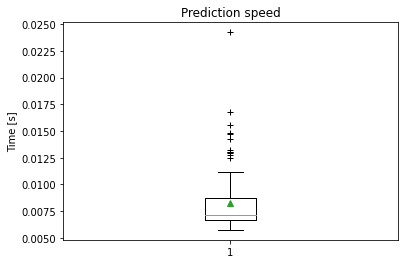

In [28]:
import time
time_l = []

for i in range(100):
    s = time.time()
    pred_t = gpr_t.predict(Xv[1])
    pred_dmp = gpr_dmp.predict(Xv[1])
    e = time.time()
    time_l.append(e-s)
    
plt.boxplot(time_l, showmeans=True, sym='+')
plt.ylabel("Time [s]")
plt.title("Prediction speed")
plt.savefig("/home/jiayun/Desktop/run_time.jpg", dpi=200)

In [15]:
np.save("/home/jiayun/MotionLearning/suboptimal_planner/learning/6dof/X.npy", X)
np.save("/home/jiayun/MotionLearning/suboptimal_planner/learning/6dof/Y.npy", Y)

In [29]:
diff = pred[:,-1] - Yv[:,-1]
100 * (diff).sum() / Yv[:,-1].sum()

0.018555502413372886

In [30]:
for i in range(200):
    plot_res_6dof(sym_robot.q_max, sym_robot.q_min, sym_robot.qd_max, sym_robot.qdd_max, i, pred, Xv, Yv, Trueth,\
                  qd_trueth, qdd_trueth, tau_trueth, dmp3=FlexDMP, DMP_ORDER=DMP_ORDER)


KeyboardInterrupt



Error in callback <function flush_figures at 0x7fafb8fd35e0> (for post_execute):



KeyboardInterrupt

